# Statistical Learning Project 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import math
import sklearn 
import seaborn as sns
from sklearn import cluster, datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl
from qiskit_machine_learning.datasets import ad_hoc_data
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.impute import SimpleImputer 
from datetime import datetime 
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from matplotlib import colormaps
from sklearn.metrics import accuracy_score
from tabulate import tabulate


# DBSCAN 
The following is an implementation of DBSCAN.

"dist" is a function that returns the Euclidean distance between two points ("p" and "q") in a multi-dimensional space.

In [31]:
def dist(p,q):
    return math.sqrt(np.power(p-q,2).sum())

The function "eps_vicinato" determines if two points "p" and "q" are within a certain proximity or neighborhood of each other, based on a specified distance threshold "eps".

In [32]:
def eps_vicinato(p,q,eps):
    return dist(p,q) < eps 

The function below, "region_query", calculates the distance between the point "i" and every other point in the dataset and then returns only those points that are within a distance "eps" from "i".  

In [33]:
def region_query(dataset,i,eps):
    neighbors = []   # this list will store the indices of the points that are within "eps" from "i"
    for j in range(len(dataset)):
        if eps_vicinato(dataset[i], dataset[j], eps): # if true
            neighbors.append(j)  # we add the point "j" to the "neighbor" list
    return neighbors
        

The function below grows a new cluster with label "cluster" from the point "i". This function expands the cluster by finding all points in the neighborhood of the initial point and labeling them as part of the same cluster.

In [34]:
"""  
Parameters:
dataset: A multi-dimensional NumPy array where each row represents a point in the dataset.

labels: A list or array that tracks the cluster assignment for each point. 
Unassigned points are initially labeled as 0.
Noise points are labeled as -1.
Points in a cluster are labeled with a positive integer corresponding to the cluster number.

i: The index of the initial point that starts the cluster expansion.

punti_vicini: A list of points that are within the eps-neighborhood of the initial point "i". This list is generated by the region_query function.

cluster: The current cluster label (a positive integer) that is being assigned to points in the cluster.

eps: The maximum distance that defines the neighborhood around a point.

minpts: The minimum number of points required to form a dense region. 

"""
# 
# 
# Parameter: 
# 
def expand_cluster(dataset,labels,i,punti_vicini,cluster,eps,minpts):
        labels[i] = cluster
        j = 0
        processed_points = set() # A set to keep track of already processed points to avoid reprocessing them

        while j < len(punti_vicini):
                vicino = punti_vicini[j]
                if vicino in processed_points:  # Skip already processed points
                        j += 1
                        continue

                processed_points.add(vicino)  # Add "vicino" to the processed set
        
                if labels[vicino] == -1:  # It was previously considered noise
                        labels[vicino] = cluster
                elif labels[vicino] == 0:  # The point was still unassigned
                        labels[vicino] = cluster
                neighbors = region_query(dataset, vicino, eps)  # We found eps-neighbours of "vicino"
                if len(neighbors) >= minpts:   
                        punti_vicini.extend(neighbor for neighbor in neighbors if neighbor not in processed_points)  # We extend "punti_vicini" with the "neighbors" that have not been processed yet
                j += 1 

        # the loop continues until all points in "punti_vicini" has been processed



In [35]:
"""
Implements the DBSCAN clustering algorithm.
    
Parameters:
dataset (array-like): Dataset to be clustered.
eps (float): The maximum distance to be considered neighbors.
minpts (int): The minimum number of points to form a dense region (a cluster).
    
Returns:
list: Cluster labels for each point (-1 for noise).
"""



def dbscan(dataset, eps, minpts):
    
    labels = [0]*len(dataset)  # list that contains the cluster label for each point of the dataset
    cluster = 0  # the current cluster

    for i in range(len(dataset)):
        if not (labels[i]==0): # if the point has already been labeled then we continue to the next point
            continue   
        punti_vicini = region_query(dataset, i, eps)
        if len(punti_vicini) < minpts : 
            labels[i] = -1       # it's noise

        else :
            cluster +=1    # cluster label is incremented and the cluster is expanded
            expand_cluster(dataset, labels,i, punti_vicini, cluster, eps, minpts)
    
    return labels


In [36]:
"""
Function to plot the elements of a dataset, coloring them differently to highlight 
their cluster memberships (labels in "assegnazioni").
Parameters:
dataset (array-like): The dataset to be plotted.
assignments (list): Cluster labels for each point.
"""

def plot(dataset,assegnazioni=None):
    plt.scatter(dataset[:,0],dataset[:,1],c=assegnazioni,cmap="Set2")  # winter
    plt.title("Cluster Visualization")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.savefig("cluster.pdf", format= "pdf")
    plt.show()
    


# Datasets
DBSCAN will be applied and tested on several datasets. Some of these datasets are synthetically generated, allowing us to highlight the strengths and limitations of DBSCAN. Another dataset consists of real-world data to demonstrate a practical application.


# Generated Datasets
The generated datasets will include examples where DBSCAN faces challenges, such as when clusters have significantly varying densities or are positioned very close to each other, as well as an example where DBSCAN performs effectively.


In [9]:
# This function generates a dataset with a specified number of points using the "Two Moons" configuration.

def dataset_caso_buono(numero_punti):
    
    x, assegnazioni = make_moons(numero_punti, noise = 0.10, random_state = 42)
    return x,assegnazioni


In [10]:
# This function allows me to generate a synthetic dataset where the clusters have varying densities.

def dataset_caso_cattivo1(numero_punti: int, vettore_medie: list[list], vettore_var: list[float] ):

    cluster = [0]*len(vettore_medie)
    assegnazioni = []

    for i in range(len(vettore_medie)):
        media = vettore_medie[i]
        var = vettore_var[i]
        c = np.random.randn(numero_punti, 2)    # Random points in a 2D space
        sigma = np.eye(2)*var
        mu = np.array(media)
        cluster[i] = c@sigma + mu
        a = [i]*numero_punti
        assegnazioni = assegnazioni + a


    return np.concatenate(cluster,axis=0), assegnazioni


In [11]:
# This function generates a synthetic dataset of points clustered around some specified centers, with a specified number of points and cluster spread. 
# This allow the generation of clusters relatively close to each other. 

def dataset_caso_cattivo2(numero_punti: int, centers : list[list], cluster_std : float ):

    x, assegnazioni = make_blobs(numero_punti, 2, centers = centers, cluster_std = cluster_std, center_box=(-10.0, 10.0), shuffle=True, random_state=None, return_centers=False)
        
    return x, assegnazioni

### Visualization of Generated Datasets
Below are the plots of the generated datasets.

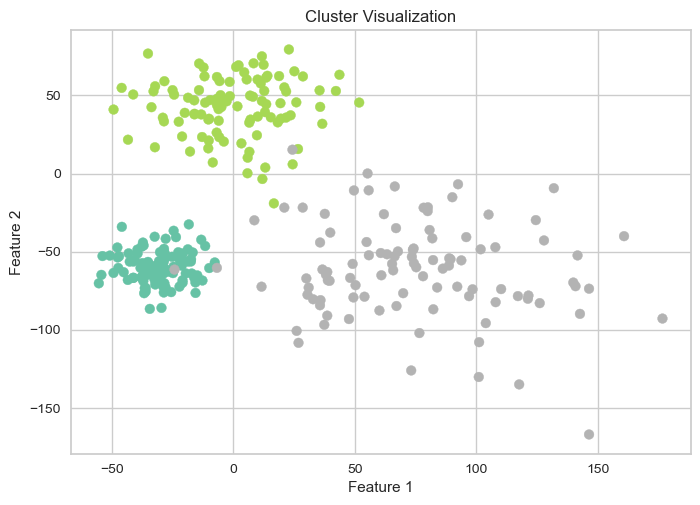

In [12]:
# Plot of the generated dataset with varying density.

dataset1,assegnazioni1 = dataset_caso_cattivo1(numero_punti = 100, vettore_medie = [[-30, -60], [0, 40], [75, -60]], vettore_var = [12, 20, 35])
plot(dataset1, assegnazioni1)

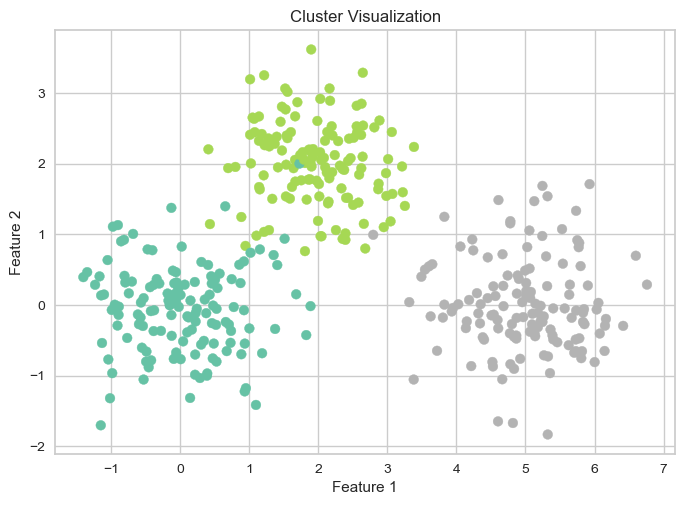

In [13]:
# Plot of the generated dataset with nearby clusters. 

dataset2,assegnazioni2 = dataset_caso_cattivo2(numero_punti = 400, centers = [[0, 0], [2,2], [5, 0]], cluster_std = 0.7)
plot(dataset2,assegnazioni2)


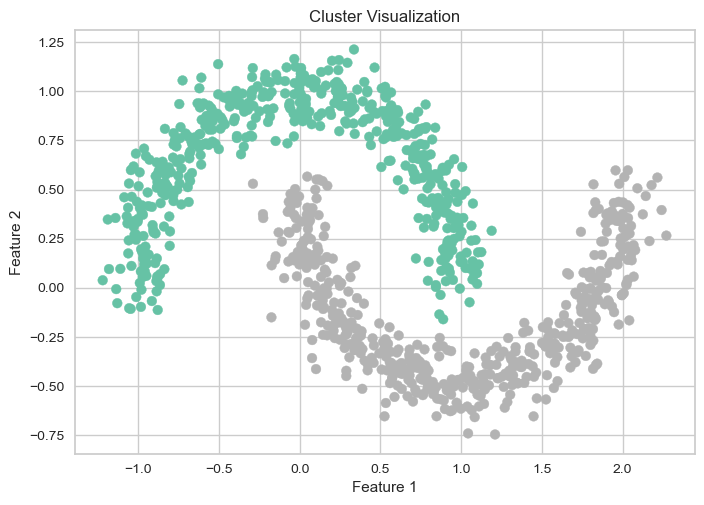

In [14]:
dataset_moon,assegnazioni = dataset_caso_buono(1000)
plot(dataset_moon,assegnazioni)



## Application of DBSCAN on Generated Data
 

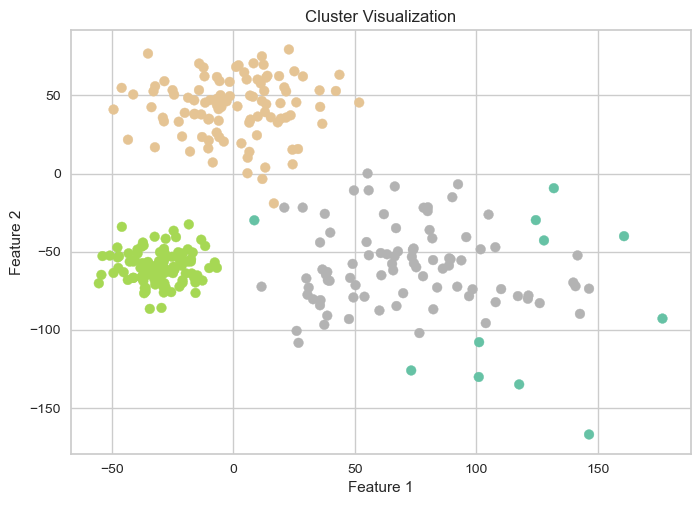

In [15]:
# Applying DBSCAN to the dataset with varying densities

labels1 = dbscan(dataset1, eps=20, minpts=6)      
plot(dataset1,labels1)

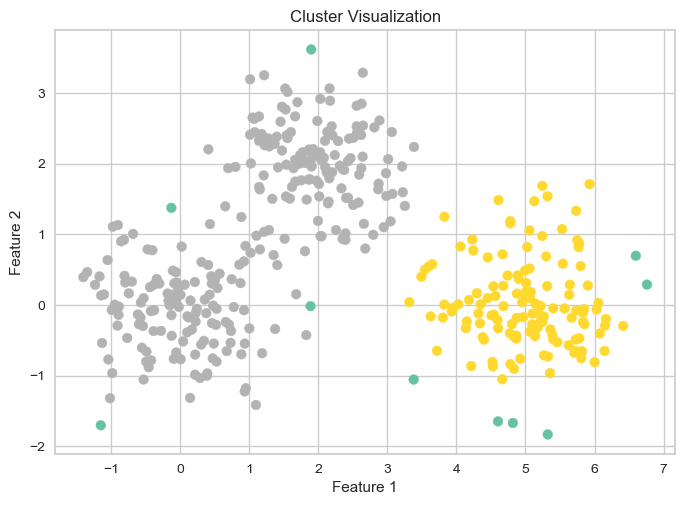

In [16]:
# Applying DBSCAN to the dataset with nearby clusters

labels2 = dbscan(dataset2 ,eps=0.5, minpts=4)
plot(dataset2,labels2)

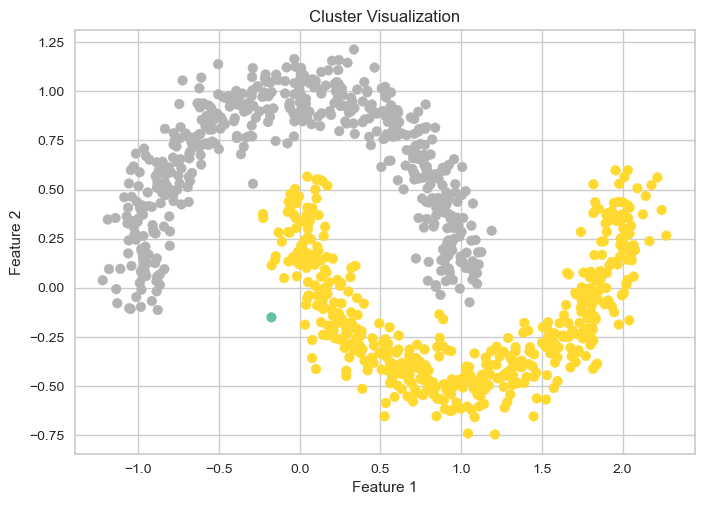

In [17]:
# Applying DBSCAN to the "Two Moons" dataset

labels_moon = dbscan(dataset_moon ,eps=0.168, minpts=9)
plot(dataset_moon,labels_moon)



## Application of other Clustering Methods on Generated Data 
We compare DBSCAN with other clustering techniques like K-means++, Spectral Clustering, and Hierarchical Clustering.

### K-means++

c:\Users\chiar\miniforge3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


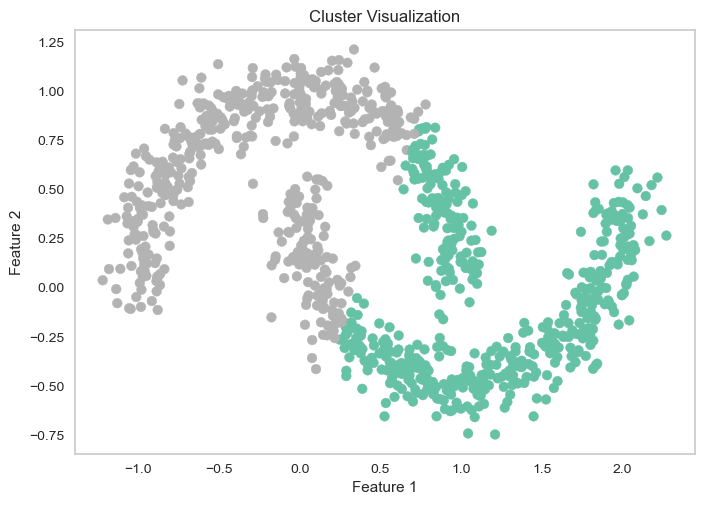

In [18]:
# K-means on the "Two Moons" dataset

kmeans = KMeans(2)
labels_k_moon = kmeans.fit_predict(dataset_moon)


plt.grid(False)

plot(dataset_moon,labels_k_moon)

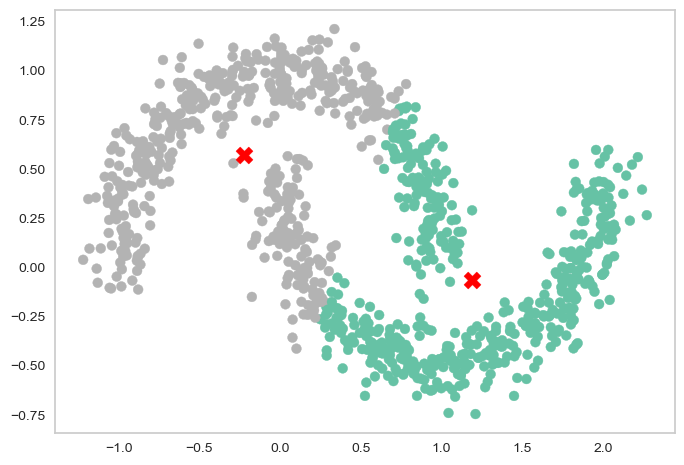

In [19]:

# Get the cluster centroids
centroids = kmeans.cluster_centers_


plt.scatter(dataset_moon[:, 0], dataset_moon[:, 1], c=labels_k_moon, s=50, cmap='Set2', alpha=1)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=150, marker='X')  # Plot centroids


plt.grid(False)

plt.show()


c:\Users\chiar\miniforge3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


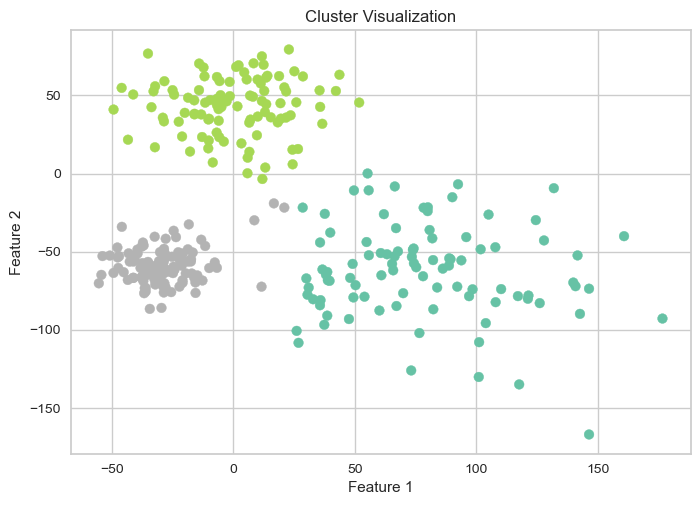

In [20]:
# K-means on the dataset with varying densities

kmeans = KMeans(3)
labels_k_1 = kmeans.fit_predict(dataset1)

plot(dataset1,labels_k_1)

c:\Users\chiar\miniforge3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


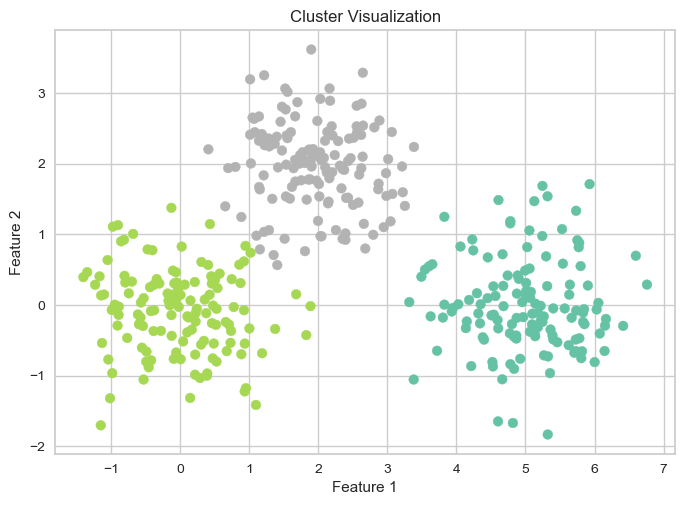

In [21]:
# K-means on the dataset with nearby clusters

kmeans = KMeans(3)
labels_k_2 = kmeans.fit_predict(dataset2)

plot(dataset2,labels_k_2)

### Spectral Clustering

c:\Users\chiar\miniforge3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


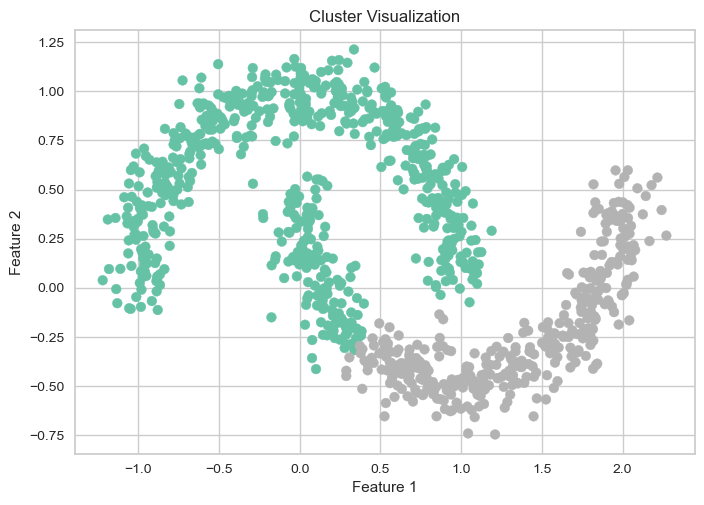

In [22]:
# Spectral Clustering on the "Two Moons" dataset

spectral = SpectralClustering(n_clusters=2,
                              affinity='nearest_neighbors',
                              n_neighbors=10,
                              random_state=0).fit(dataset_moon)
labels_spectral_moon = spectral.labels_
plot(dataset_moon,labels_spectral_moon)

c:\Users\chiar\miniforge3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


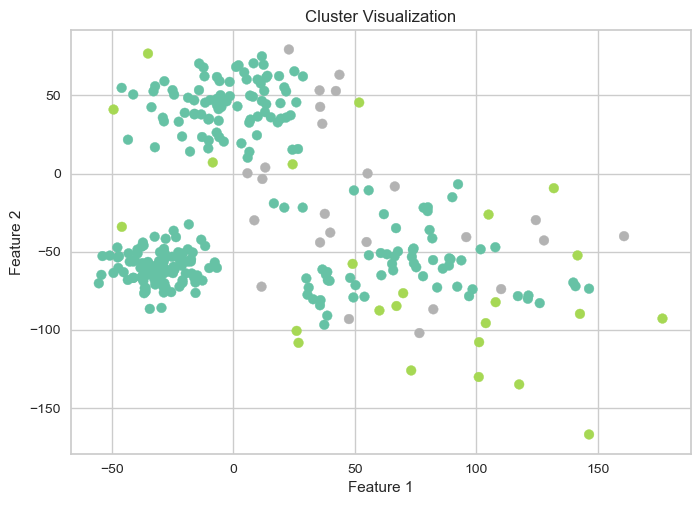

In [23]:
# Spectral Clustering on the dataset with varying densities

spectral1 = SpectralClustering(n_clusters=3,n_neighbors=10,
        assign_labels='discretize',
        random_state=0).fit(dataset1)
labels_spectral_1 = spectral1.labels_
plot(dataset1,labels_spectral_1)

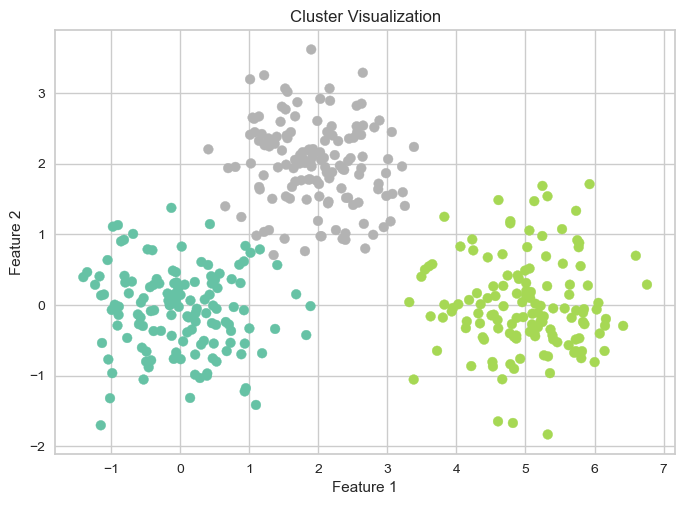

In [24]:
# Spectral Clustering on the dataset with nearby clusters

spectral2 = SpectralClustering(n_clusters=3,
        assign_labels='discretize',
        random_state=0).fit(dataset2)
labels_spectral_2 = spectral2.labels_
plot(dataset2,labels_spectral_2)

### Hierarchical Clustering

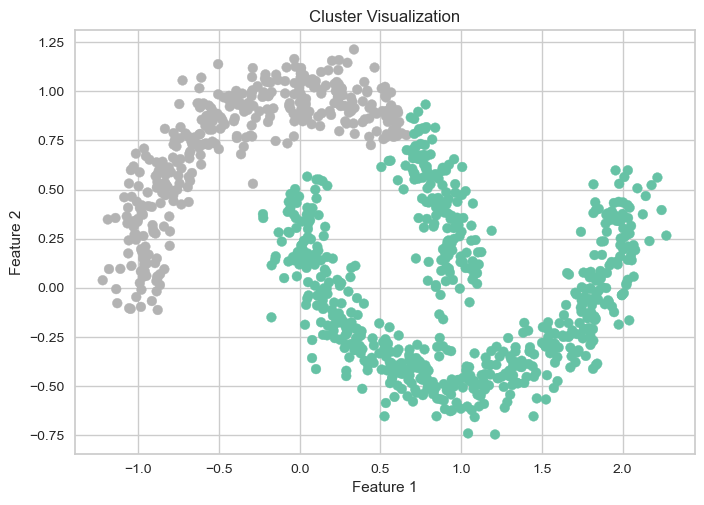

In [25]:
# Hierarchical Clustering on the "Two Moons" dataset

hierarchical_moon = AgglomerativeClustering(2,linkage='average').fit(dataset_moon)   # Changed the linkage, tried average,single,complete,ward but still doesn't perform well
labels_h_moon = hierarchical_moon.labels_
plot(dataset_moon,labels_h_moon)

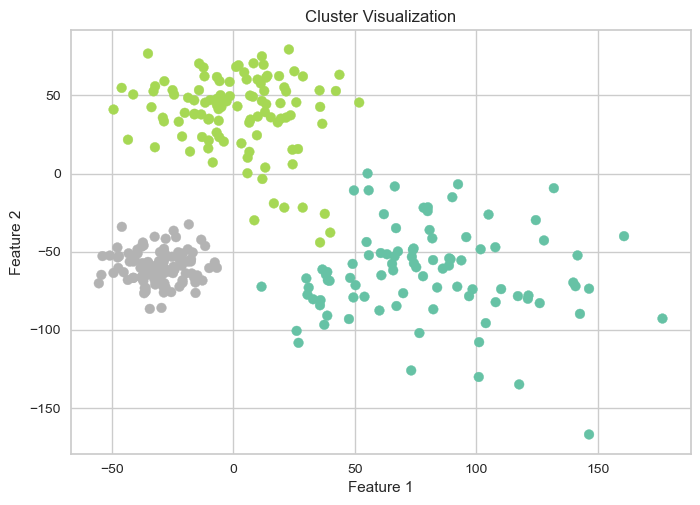

In [26]:
# Hierarchical Clustering on the dataset with varying densities

hier1 = AgglomerativeClustering(3).fit(dataset1)
labels_h_1 = hier1.labels_
plot(dataset1,labels_h_1)

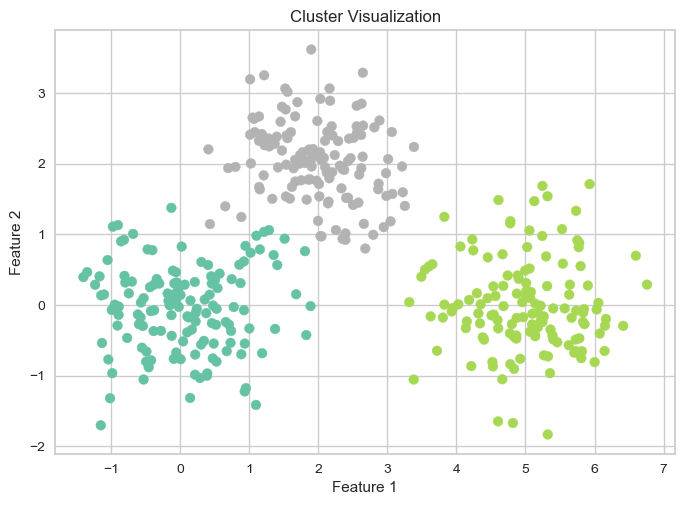

In [27]:
# Hierarchical Clustering on the dataset with nearby clusters

hier2 = AgglomerativeClustering(3).fit(dataset2)
labels_h_2 = hier2.labels_
plot(dataset2,labels_h_2)

# Parameters Estimation DBSCAN
k-dist graph


In [28]:

# MinPts corresponds to the number of nearest neighbors (including the point itself)
minpts = 25
example_dataset = pca_fittata3

# Compute the k-nearest neighbors distances
neigh = NearestNeighbors(n_neighbors = minpts)
nbrs = neigh.fit(example_dataset)
distances, indices = nbrs.kneighbors(example_dataset)

# Sort distances to the k-th nearest neighbor (minpts-th)
distances = np.sort(distances[:, minpts-1])

# Plot the distances to find the "knee"
plt.plot(distances)
plt.ylabel(f'{minpts}-nearest neighbor distance')
plt.xlabel('Points sorted by distance')
plt.title('k-NN Distance Plot')
plt.grid(True)
plt.savefig("kdist.pdf", format= "pdf")
plt.show()

NameError: name 'pca_fittata3' is not defined

# Datasets Reale

In [37]:
dataset = pd.read_csv("archive (1)/marketing_campaign.csv", delimiter='\t')
dataset.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

## Pre Processing 

In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [39]:
#Create 'Age' feature from customer's birth year
dataset["Age"] = 2024-dataset["Year_Birth"]

In [40]:
#Total spendings on various items
dataset["MntTotal"] = dataset["MntWines"]+ dataset["MntFruits"]+ dataset["MntMeatProducts"]+ dataset["MntFishProducts"]+ dataset["MntSweetProducts"]+ dataset["MntGoldProds"]

In [41]:
dataset['Total_Online_Purchases'] = dataset['NumWebPurchases'] + dataset['NumCatalogPurchases']
dataset['Total_Store_Purchases'] = dataset['NumStorePurchases']

In [42]:
#Create 'Num_Accepted' feature from the sum of previous marketting campaigns that were accepted by the customer
dataset['Num_Accepted'] = dataset.AcceptedCmp1.values + dataset.AcceptedCmp2.values + \
                                dataset.AcceptedCmp3.values + dataset.AcceptedCmp4.values + \
                                dataset.AcceptedCmp5.values + dataset.Response.values

In [43]:
#Create 'Fam_Size' feature from the marriage status, number of kids/teens
marital_map = {'Absurd': 1, 'Alone': 1, 'YOLO': 1, 'Single': 1,
              'Married': 2, 'Together': 2, 'Widow': 1, 'Divorced': 1}
dataset['Marital_Status'] = dataset.Marital_Status.map(marital_map)        #    Maps all singles as 1, couples as 2
dataset['Num_Kids'] = dataset.Kidhome.values + dataset.Teenhome.values
dataset['Fam_Size'] = dataset.Marital_Status.values + dataset.Num_Kids.values

In [44]:
dataset['Dt_Customer'] = pd.to_datetime(dataset['Dt_Customer'],format='%d-%m-%Y')
dataset['Dt_Customer'] = dataset['Dt_Customer'].dt.year

In [45]:
# Number of Years a customer has been with the company
dataset['Years_With_Company'] = 2024 - dataset['Dt_Customer']

In [46]:
dataset['Years_With_Company'].value_counts()

Years_With_Company
11    1189
10     557
12     494
Name: count, dtype: int64

In [47]:
dataset['Education'].value_counts()

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

In [48]:
dataset.Education = dataset.Education.replace(
    {
        "Basic": 0,        # 0 = "Undergraduate"        
        "2n Cycle": 0,
        "Graduation": 1,        # 1 = "Graduate"
        "Master": 2,         # 2 =  "Postgraduate"
        "PhD": 2,
    }
)

C:\Users\chiar\AppData\Local\Temp\ipykernel_8360\712130703.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset.Education = dataset.Education.replace(


In [49]:
dataset['Education'].value_counts()

Education
1    1127
2     856
0     257
Name: count, dtype: int64

In [50]:
to_drop = ['Year_Birth','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
            'AcceptedCmp5','Kidhome', 'Teenhome','Marital_Status', 'Z_CostContact', 
            'Z_Revenue', 'ID','Dt_Customer','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','Num_Kids','Response' ]
data = dataset.drop(to_drop, axis=1)  

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Education               2240 non-null   int64  
 1   Income                  2216 non-null   float64
 2   Recency                 2240 non-null   int64  
 3   MntWines                2240 non-null   int64  
 4   MntFruits               2240 non-null   int64  
 5   MntMeatProducts         2240 non-null   int64  
 6   MntFishProducts         2240 non-null   int64  
 7   MntSweetProducts        2240 non-null   int64  
 8   MntGoldProds            2240 non-null   int64  
 9   NumDealsPurchases       2240 non-null   int64  
 10  NumWebVisitsMonth       2240 non-null   int64  
 11  Complain                2240 non-null   int64  
 12  Age                     2240 non-null   int64  
 13  MntTotal                2240 non-null   int64  
 14  Total_Online_Purchases  2240 non-null   

In [52]:
data['Recency'].value_counts()

Recency
56    37
30    32
54    32
46    31
92    30
      ..
41    15
59    14
22    13
7     12
44    11
Name: count, Length: 100, dtype: int64

In [53]:
data.isna().sum()


Education                  0
Income                    24
Recency                    0
MntWines                   0
MntFruits                  0
MntMeatProducts            0
MntFishProducts            0
MntSweetProducts           0
MntGoldProds               0
NumDealsPurchases          0
NumWebVisitsMonth          0
Complain                   0
Age                        0
MntTotal                   0
Total_Online_Purchases     0
Total_Store_Purchases      0
Num_Accepted               0
Fam_Size                   0
Years_With_Company         0
dtype: int64

In [54]:
data.fillna(data.mean(numeric_only=True), inplace=True)

In [55]:
data.isna().sum()


Education                 0
Income                    0
Recency                   0
MntWines                  0
MntFruits                 0
MntMeatProducts           0
MntFishProducts           0
MntSweetProducts          0
MntGoldProds              0
NumDealsPurchases         0
NumWebVisitsMonth         0
Complain                  0
Age                       0
MntTotal                  0
Total_Online_Purchases    0
Total_Store_Purchases     0
Num_Accepted              0
Fam_Size                  0
Years_With_Company        0
dtype: int64

In [56]:
data.describe()

Education         Income      Recency     MntWines    MntFruits  \
count  2240.000000    2240.000000  2240.000000  2240.000000  2240.000000   
mean      1.267411   52247.251354    49.109375   303.935714    26.302232   
std       0.652347   25037.797168    28.962453   336.597393    39.773434   
min       0.000000    1730.000000     0.000000     0.000000     0.000000   
25%       1.000000   35538.750000    24.000000    23.750000     1.000000   
50%       1.000000   51741.500000    49.000000   173.500000     8.000000   
75%       2.000000   68289.750000    74.000000   504.250000    33.000000   
max       2.000000  666666.000000    99.000000  1493.000000   199.000000   

       MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
count      2240.000000      2240.000000       2240.000000   2240.000000   
mean        166.950000        37.525446         27.062946     44.021875   
std         225.715373        54.628979         41.280498     52.167439   
min           0.000000         0.000000          0.000000      0.000000   
25%          16.000000         3.000000          1.000000      9.000000   
50%          67.000000        12.000000          8.000000     24.000000   
75%         232.000000        50.000000         33.000000     56.000000   
max        1725.000000       259.000000        263.000000    362.000000   

       NumDealsPurchases  NumWebVisitsMonth     Complain          Age  \
count        2240.000000        2240.000000  2240.000000  2240.000000   
mean            2.325000           5.316518     0.009375    55.194196   
std             1.932238           2.426645     0.096391    11.984069   
min             0.000000           0.000000     0.000000    28.000000   
25%             1.000000           3.000000     0.000000    47.000000   
50%             2.000000           6.000000     0.000000    54.000000   
75%             3.000000           7.000000     0.000000    65.000000   
max            15.000000          20.000000     1.000000   131.000000   

          MntTotal  Total_Online_Purchases  Total_Store_Purchases  \
count  2240.000000             2240.000000            2240.000000   
mean    605.798214                6.746875               5.790179   
std     602.249288                4.734179               3.250958   
min       5.000000                0.000000               0.000000   
25%      68.750000                2.000000               3.000000   
50%     396.000000                6.000000               5.000000   
75%    1045.500000               10.000000               8.000000   
max    2525.000000               28.000000              13.000000   

       Num_Accepted     Fam_Size  Years_With_Company  
count   2240.000000  2240.000000         2240.000000  
mean       0.446875     2.595089           10.971875  
std        0.890543     0.906959            0.684554  
min        0.000000     1.000000           10.000000  
25%        0.000000     2.000000           11.000000  
50%        0.000000     3.000000           11.000000  
75%        1.000000     3.000000           11.000000  
max        5.000000     5.000000           12.000000

## Boxplots

### Single Boxplots


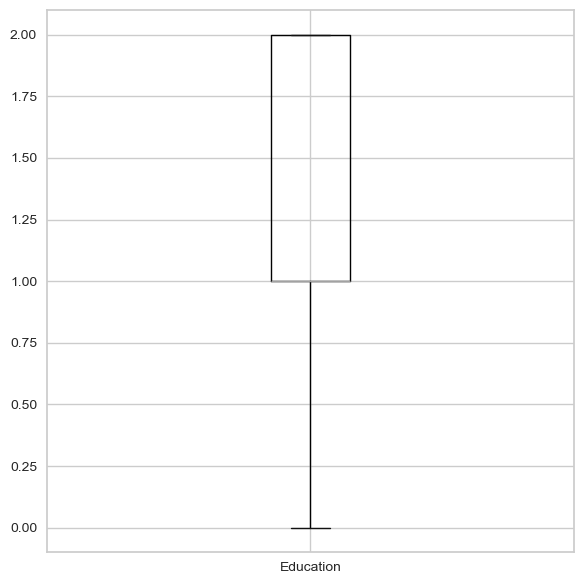

In [27]:
plt.figure(figsize=(6, 6))
data.boxplot(column=[ 'Education'])
plt.tight_layout()
plt.show()


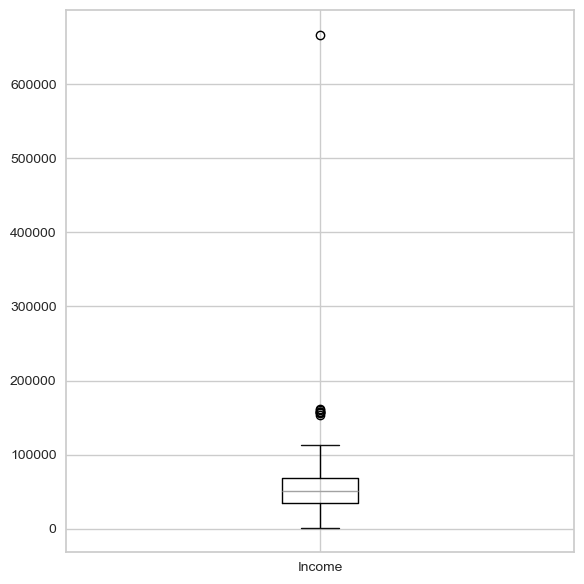

In [28]:
plt.figure(figsize=(6, 6))

data.boxplot(column=[ 'Income'])

plt.tight_layout()
plt.show()


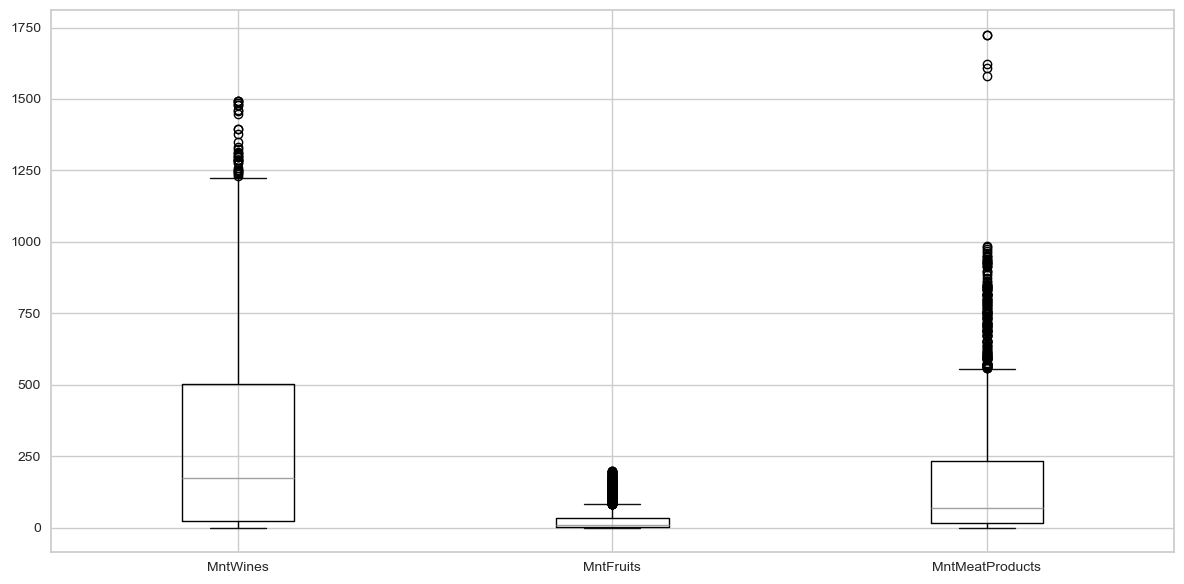

In [29]:
plt.figure(figsize=(12, 6))

data.boxplot(column=['MntWines', 'MntFruits', 'MntMeatProducts'])

plt.tight_layout()
plt.show()

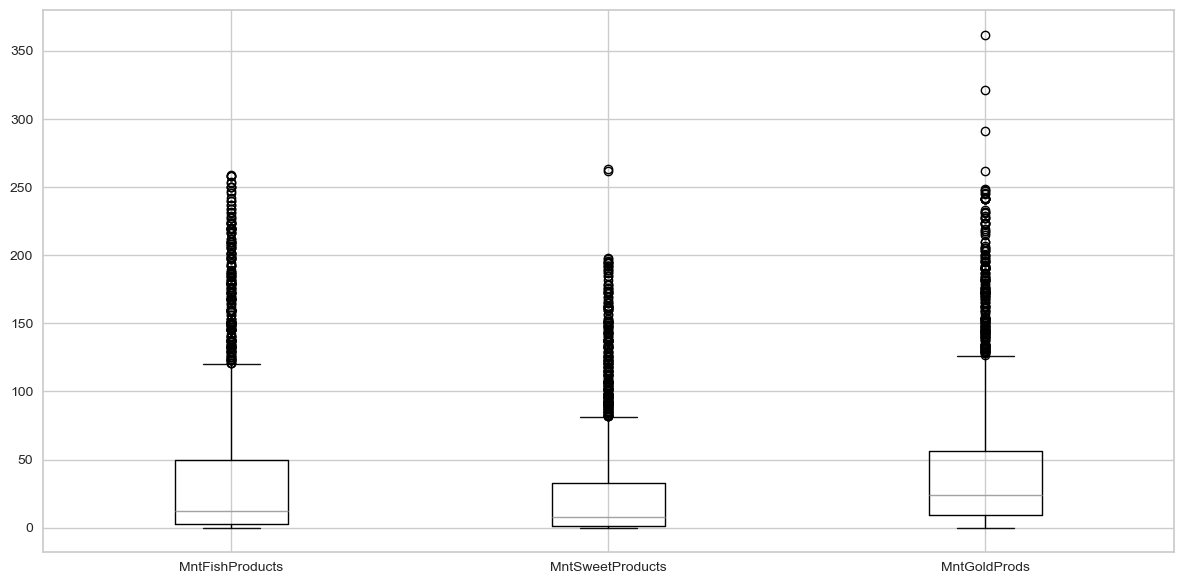

In [30]:

plt.figure(figsize=(12, 6))

data.boxplot(column=['MntFishProducts','MntSweetProducts','MntGoldProds'])

plt.tight_layout()
plt.show()

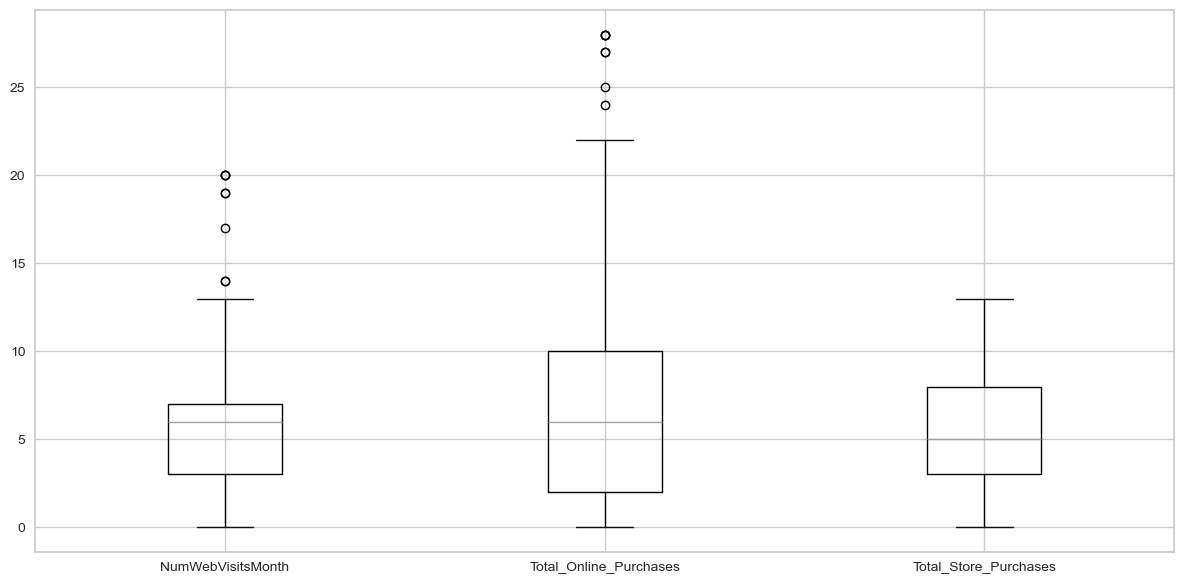

In [31]:
plt.figure(figsize=(12, 6))

data.boxplot(column=[ 'NumWebVisitsMonth','Total_Online_Purchases','Total_Store_Purchases'])

plt.tight_layout()
plt.show()

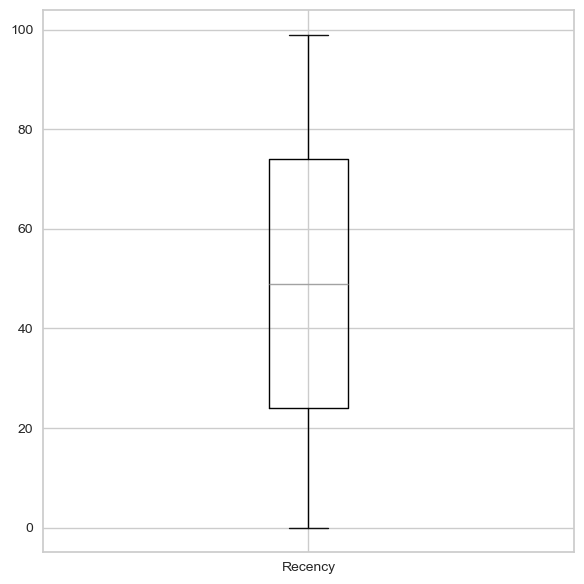

In [32]:

plt.figure(figsize=(6, 6))

boxplots = data.boxplot(column=[ 'Recency'])

plt.tight_layout()
plt.show()

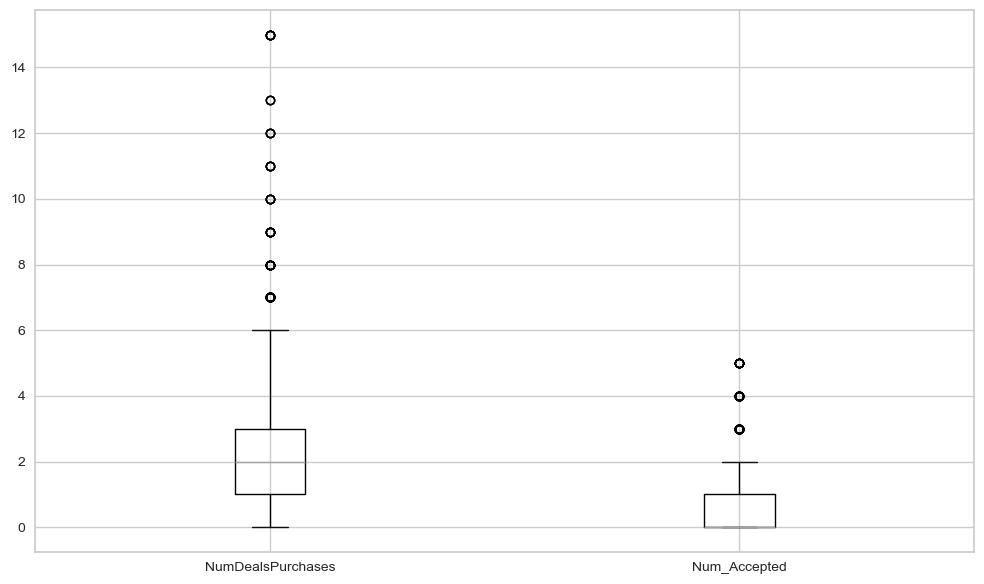

In [33]:
plt.figure(figsize=(10, 6))

data.boxplot(column=[ 'NumDealsPurchases','Num_Accepted'])

plt.tight_layout()
plt.show()

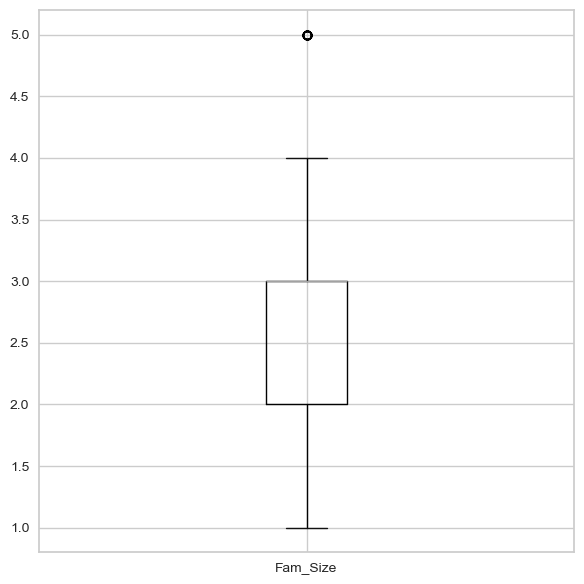

In [34]:
plt.figure(figsize=(6, 6))

data.boxplot(column=[ 'Fam_Size'])

plt.tight_layout()
plt.show() 

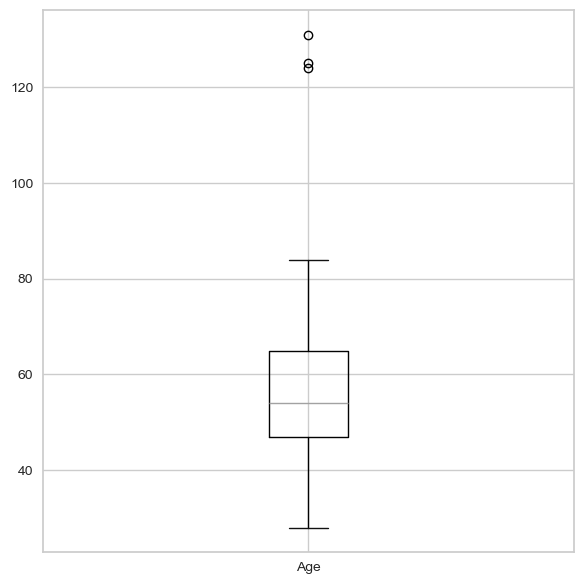

In [35]:
plt.figure(figsize=(6, 6))

data.boxplot(column=[ 'Age'])

plt.tight_layout()
plt.show()

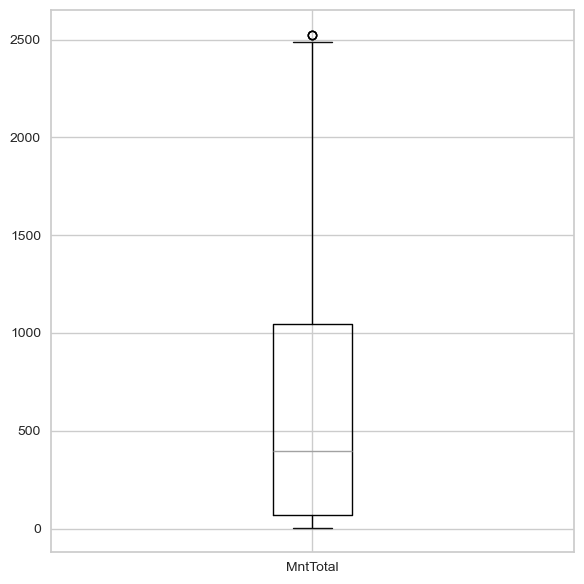

In [36]:
plt.figure(figsize=(6, 6))

data.boxplot(column=[ 'MntTotal'])

plt.tight_layout()
plt.show()

### Boxplots together

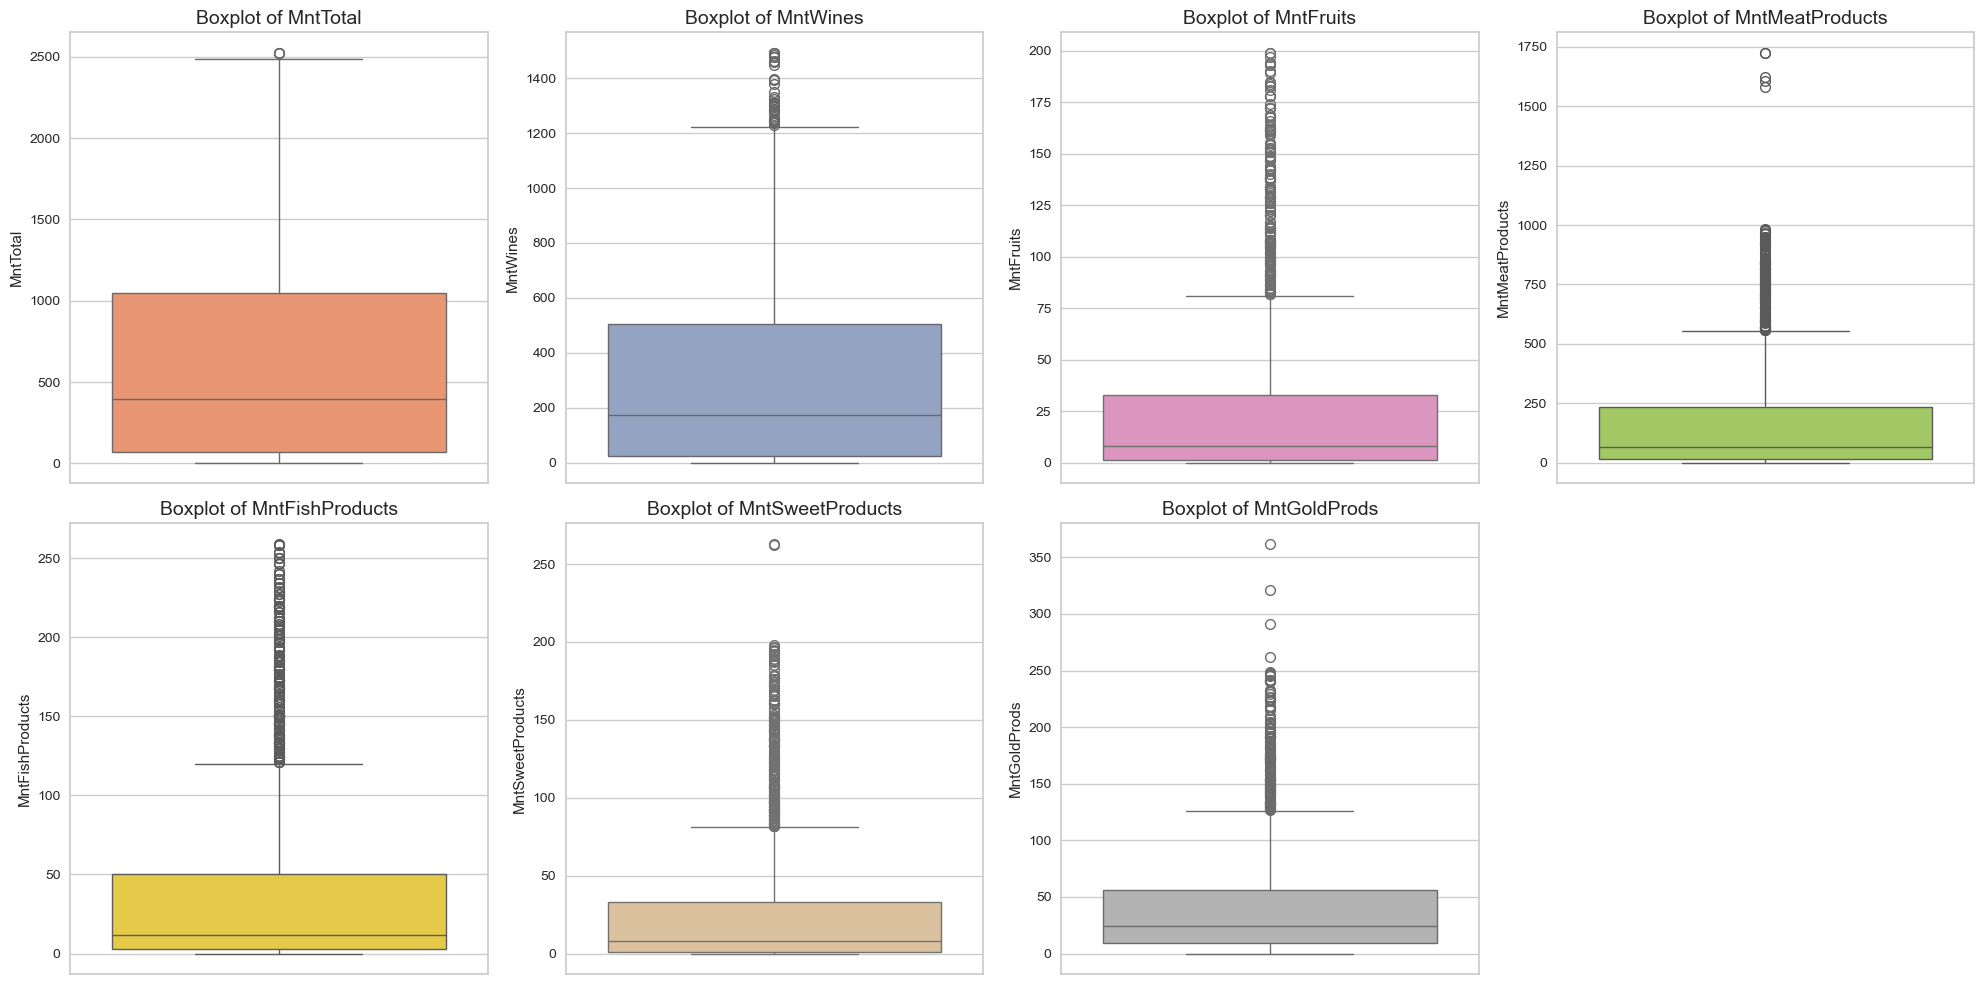

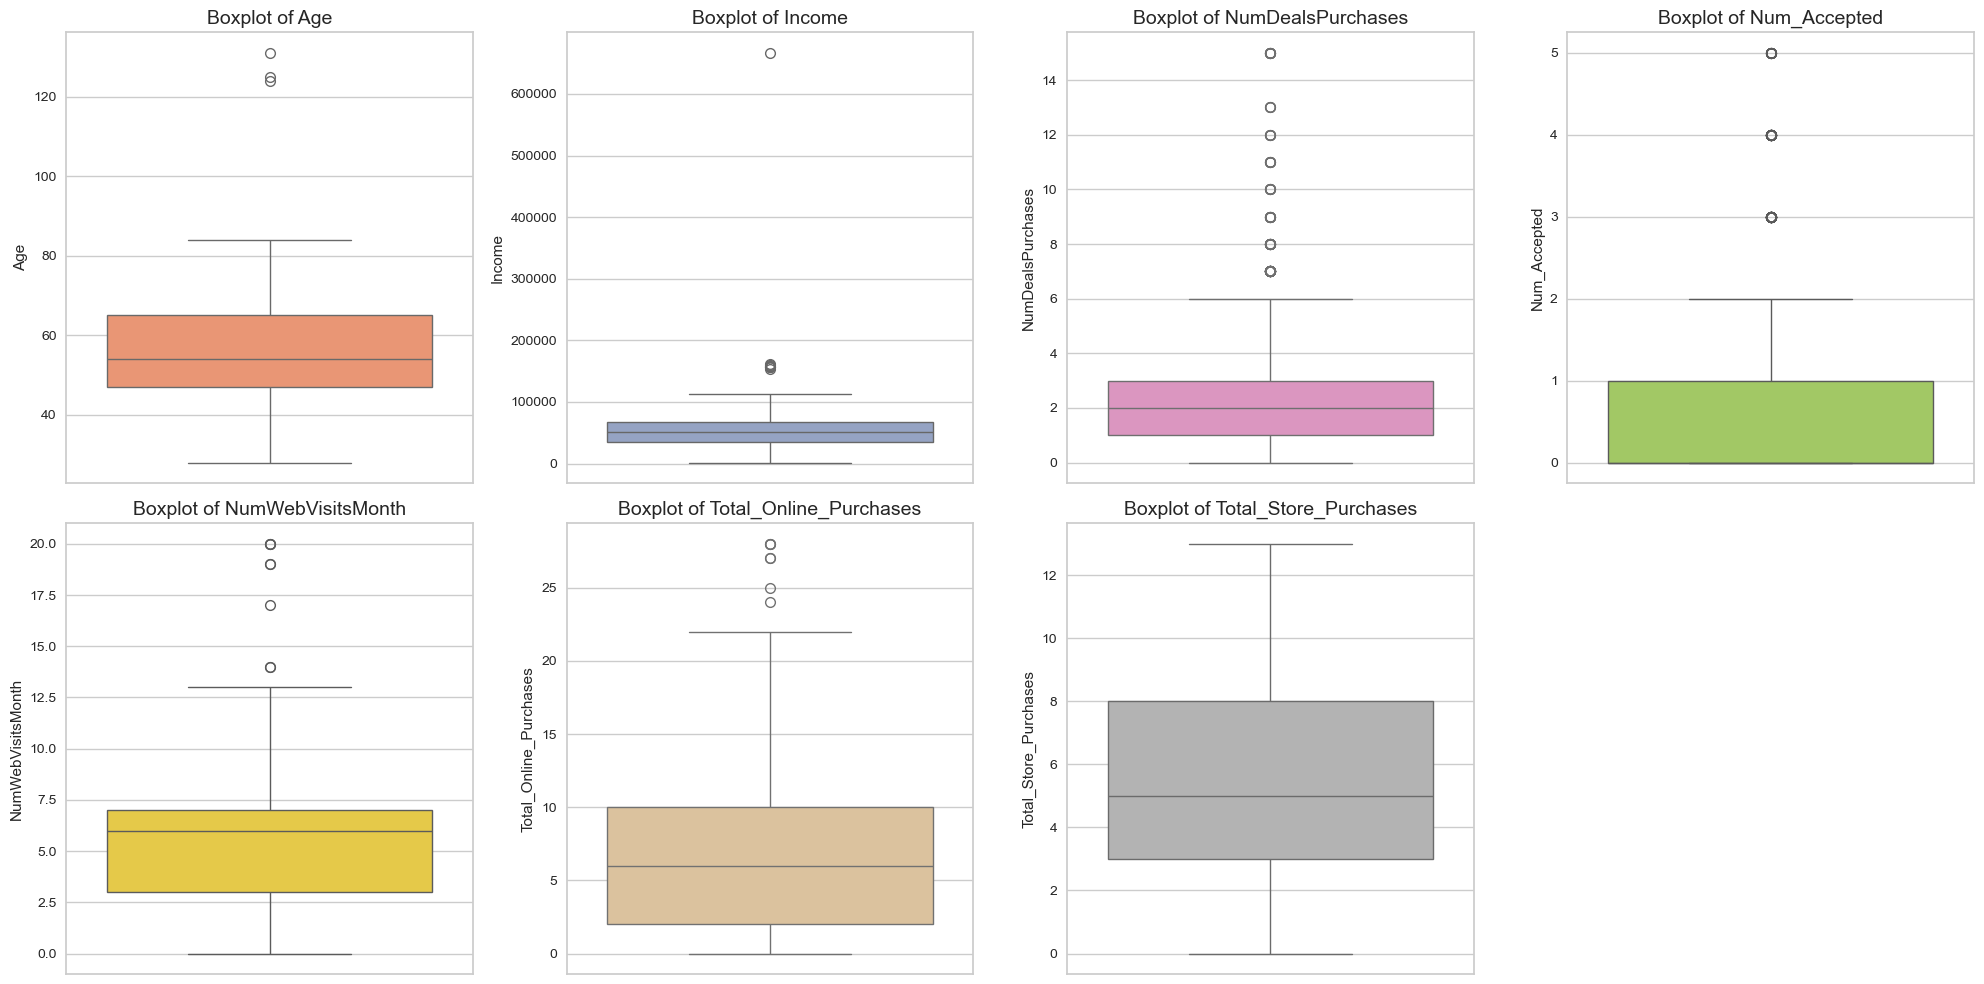

In [37]:
# Define the data columns to plot
columns1 = [ 'MntTotal', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
columns2 = ['Age', 'Income','NumDealsPurchases', 'Num_Accepted','NumWebVisitsMonth', 'Total_Online_Purchases', 'Total_Store_Purchases' ]

# Set a color palette
palette = sns.color_palette("Set2")

# Create the first figure with 8 vertical boxplots in 2 rows and 4 columns
plt.figure(figsize=(20, 10))

for i, col in enumerate(columns1, 1):
    plt.subplot(2, 4, i)  # 2 rows, 4 columns, plot i
    sns.boxplot(y=data[col], color=palette[i % len(palette)])
    plt.title(f'Boxplot of {col}', fontsize=14)

plt.tight_layout()
plt.savefig('vertical_boxplots_1.png')
plt.show()

# Create the second figure with the remaining 8 vertical boxplots in 2 rows and 4 columns
plt.figure(figsize=(20, 10))

for i, col in enumerate(columns2, 1):
    plt.subplot(2, 4, i)  # 2 rows, 4 columns, plot i
    sns.boxplot(y=data[col], color=palette[i % len(palette)])
    plt.title(f'Boxplot of {col}', fontsize=14)

plt.tight_layout()
plt.savefig('vertical_boxplots_2.png')
plt.show()


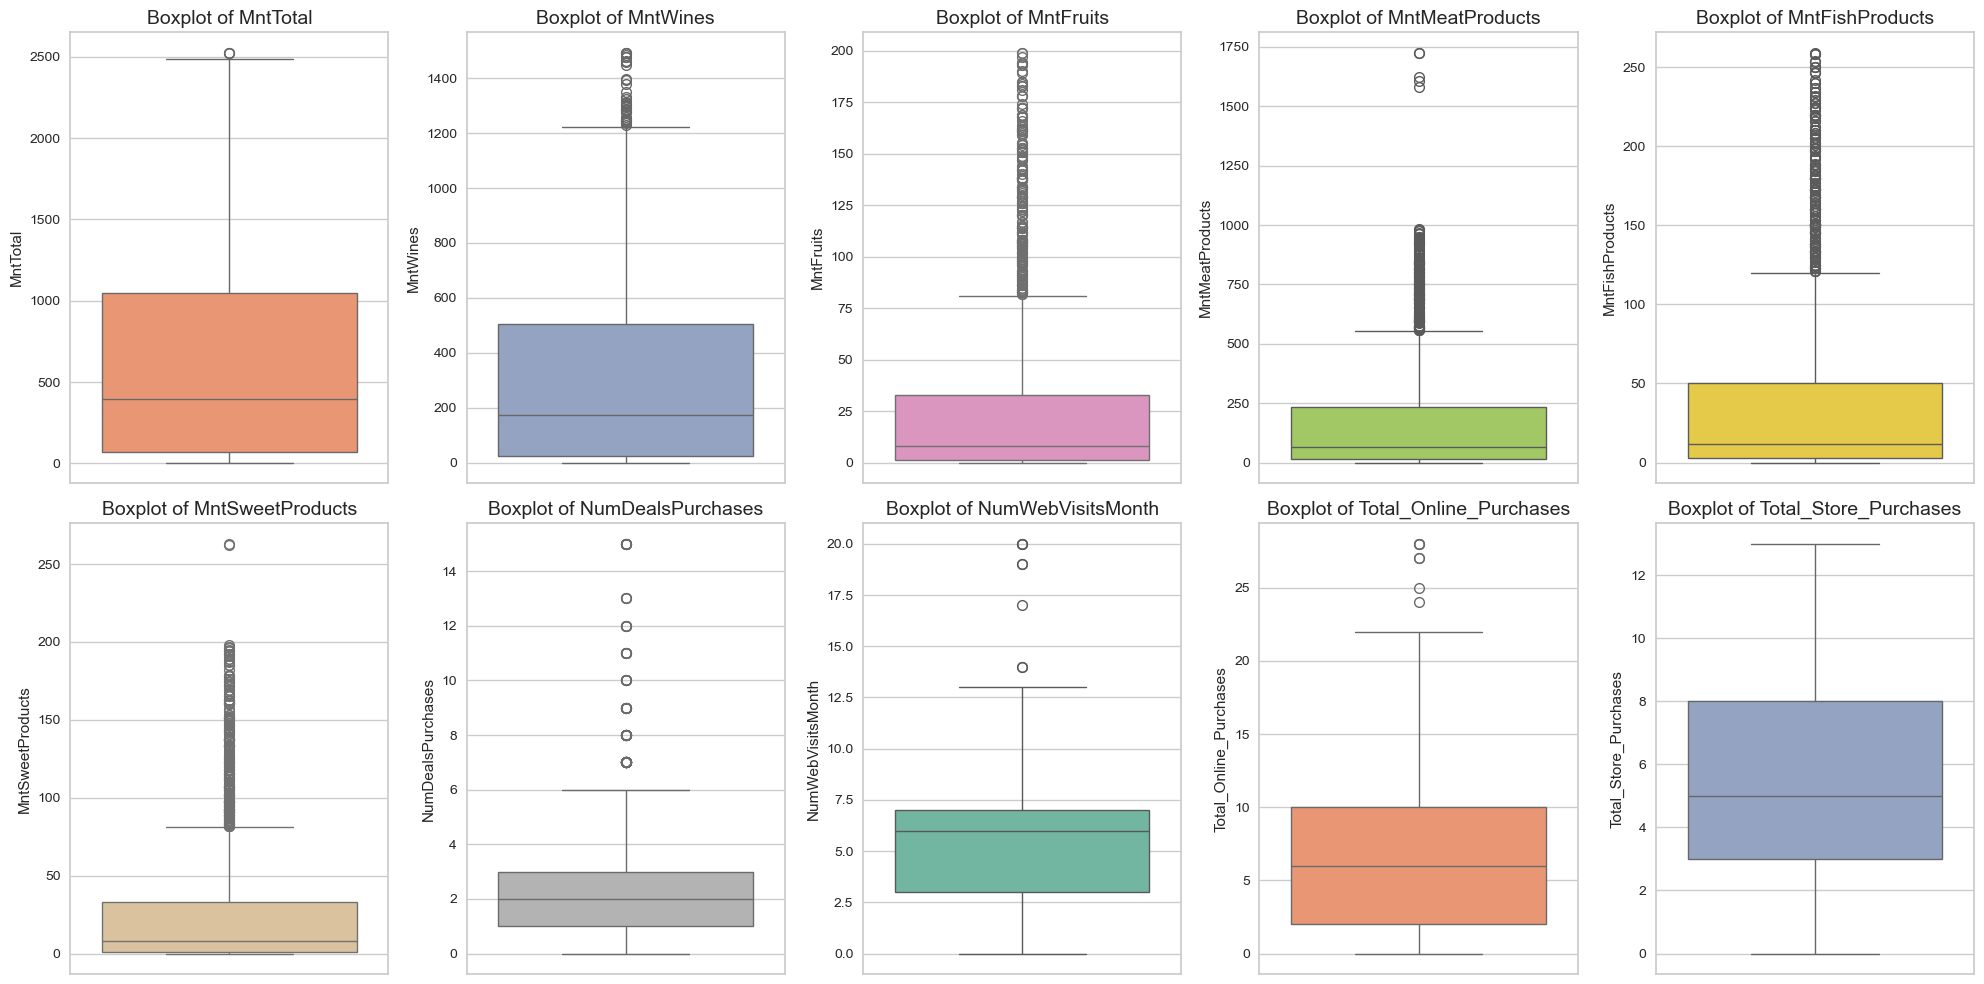

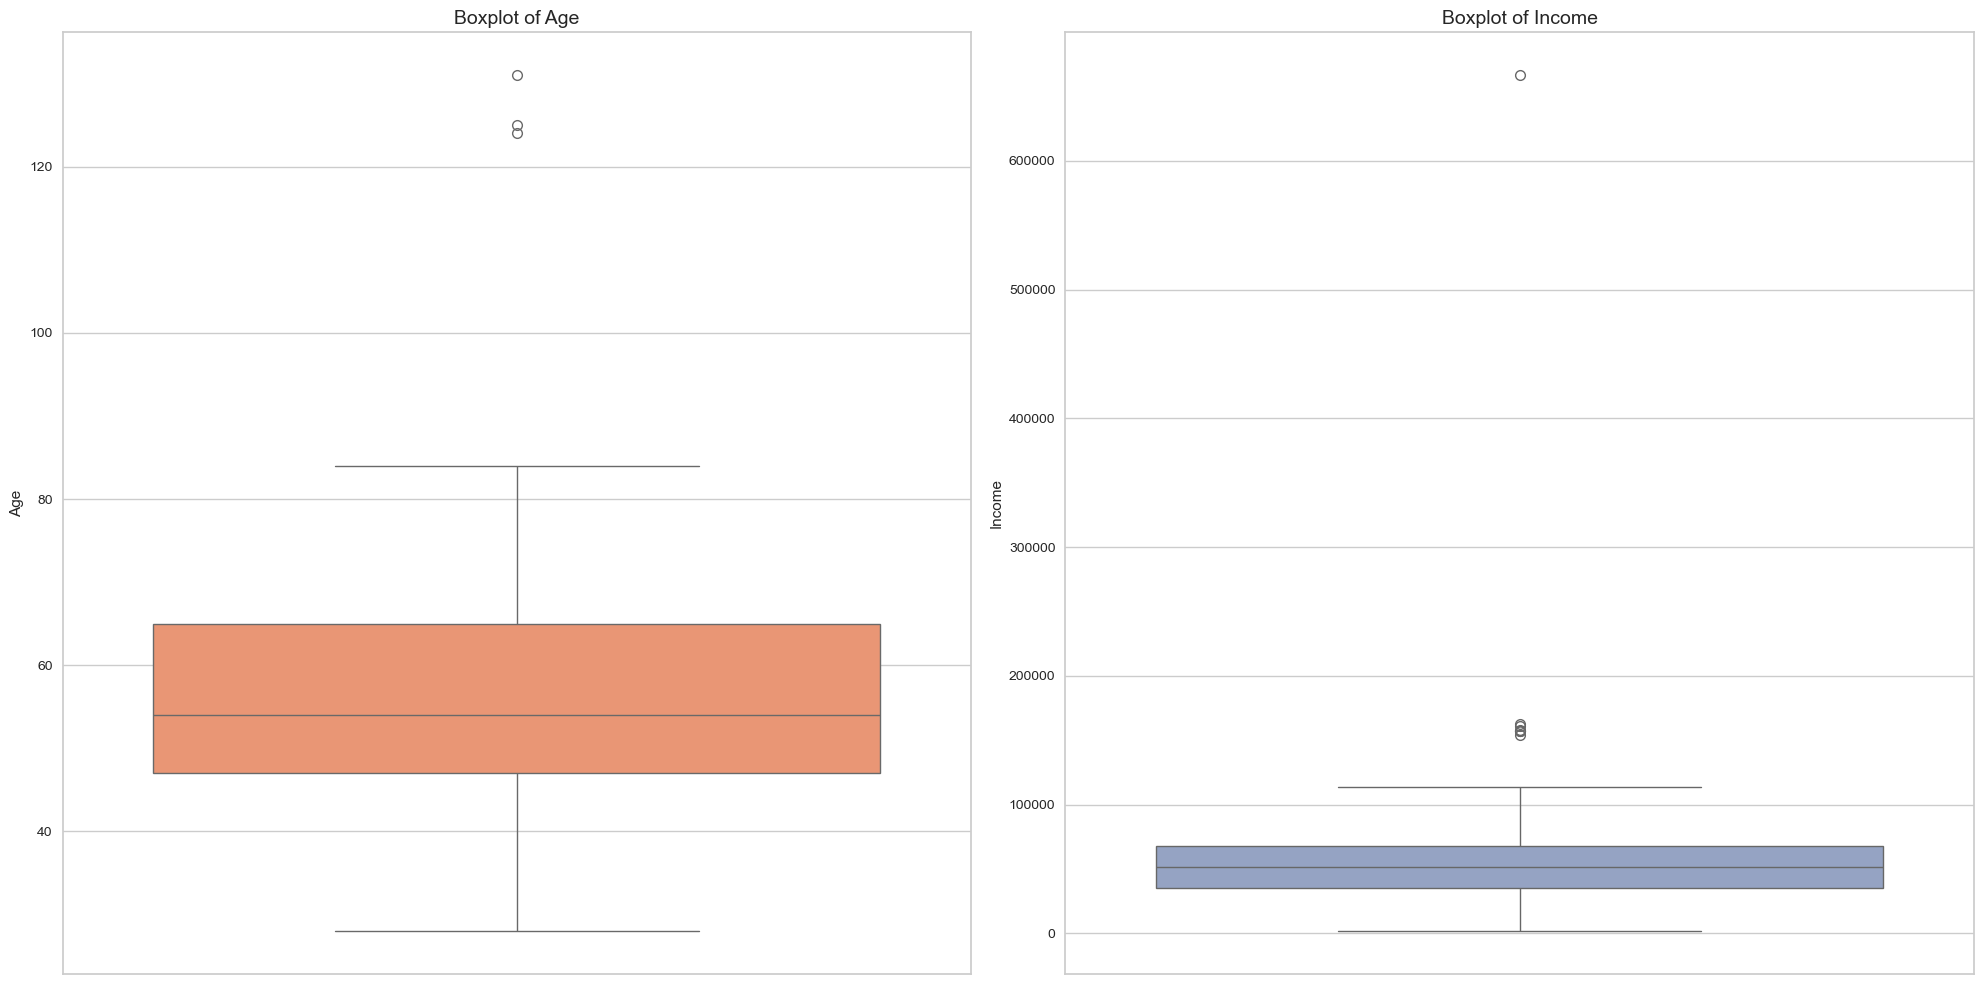

In [38]:
# Define the data columns to plot
columns1 = [ 'MntTotal', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
            'NumDealsPurchases', 'NumWebVisitsMonth', 'Total_Online_Purchases', 'Total_Store_Purchases']
columns2 = ['Age', 'Income' ]
#'Num_Accepted', 'MntGoldProds',


# Set a color palette
palette = sns.color_palette("Set2")

# Create the first figure with 12 vertical boxplots in 2 rows and 6 columns
plt.figure(figsize=(20, 10))

for i, col in enumerate(columns1, 1):
    plt.subplot(2, 5, i)  # 2 rows, 5 columns, plot i
    sns.boxplot(y=data[col], color=palette[i % len(palette)])
    plt.title(f'Boxplot of {col}', fontsize=14)

plt.tight_layout()
plt.savefig('vertical_boxplots_1_total.png')
plt.show()

# Create the second figure with the remaining 2 vertical boxplots in 1 rows and 2 columns
plt.figure(figsize=(20, 10))

for i, col in enumerate(columns2, 1):
    plt.subplot(1, 2, i)  # 1 rows, 2 columns, plot i
    sns.boxplot(y=data[col], color=palette[i % len(palette)])
    plt.title(f'Boxplot of {col}', fontsize=14)

plt.tight_layout()
plt.savefig('vertical_boxplots_2_mod.png')
plt.show()

## Removing Outliers

In [57]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 3 * IQR

# Identify outliers
outliers = ((data < (Q1 - outlier_step)) | (data > (Q3 + outlier_step)))

# Count the number of outliers in each column
outliers_count = outliers.sum()

print("Number of outliers in each column:")
print(outliers_count)

Number of outliers in each column:
Education                    0
Income                       1
Recency                      0
MntWines                     0
MntFruits                   96
MntMeatProducts             29
MntFishProducts             72
MntSweetProducts           106
MntGoldProds                49
NumDealsPurchases           24
NumWebVisitsMonth            3
Complain                    21
Age                          3
MntTotal                     0
Total_Online_Purchases       0
Total_Store_Purchases        0
Num_Accepted                10
Fam_Size                     0
Years_With_Company        1051
dtype: int64


In [58]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) specifically for Income and Age
Q1_income = data['Income'].quantile(0.25)
Q3_income = data['Income'].quantile(0.75)
IQR_income = Q3_income - Q1_income

Q1_age = data['Age'].quantile(0.25)
Q3_age = data['Age'].quantile(0.75)
IQR_age = Q3_age - Q1_age

In [59]:
# Define the outlier step for each column
outlier_step_income = 3 * IQR_income
outlier_step_age = 3 * IQR_age

# Define the lower and upper bounds for detecting outliers
lower_bound_income = Q1_income - outlier_step_income
upper_bound_income = Q3_income + outlier_step_income

lower_bound_age = Q1_age - outlier_step_age
upper_bound_age = Q3_age + outlier_step_age

In [60]:
# Filter out the outliers in Income and Age
ds = data[
    (data['Income'] >= lower_bound_income) & (data['Income'] <= upper_bound_income) &
    (data['Age'] >= lower_bound_age) & (data['Age'] <= upper_bound_age)
]

In [61]:
print(data.shape)
print(ds.shape)

(2240, 19)
(2236, 19)


### Boxplot after removing the outliers

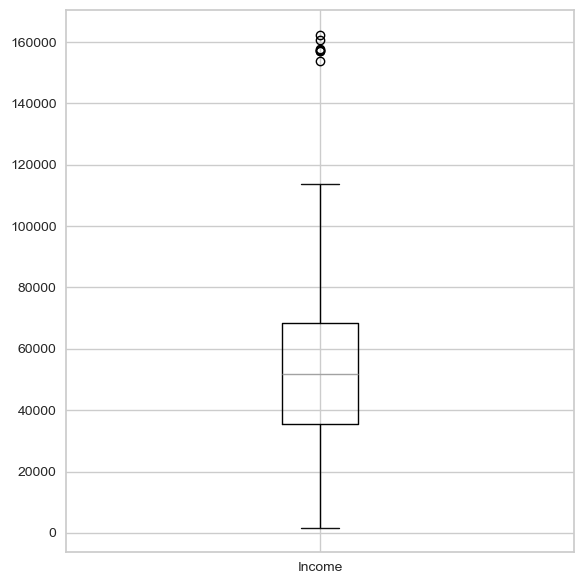

In [44]:
plt.figure(figsize=(6, 6))

ds.boxplot(column=[ 'Income'])

plt.tight_layout()
plt.show() 

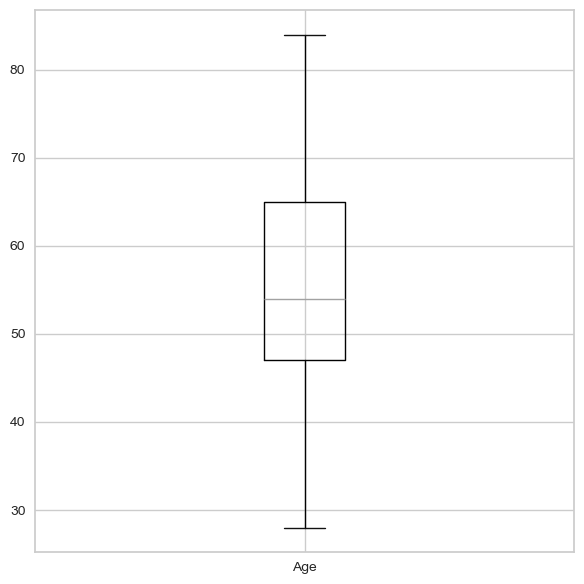

In [45]:
plt.figure(figsize=(6, 6))

ds.boxplot(column=[ 'Age'])

plt.tight_layout()
plt.show()

## Plots


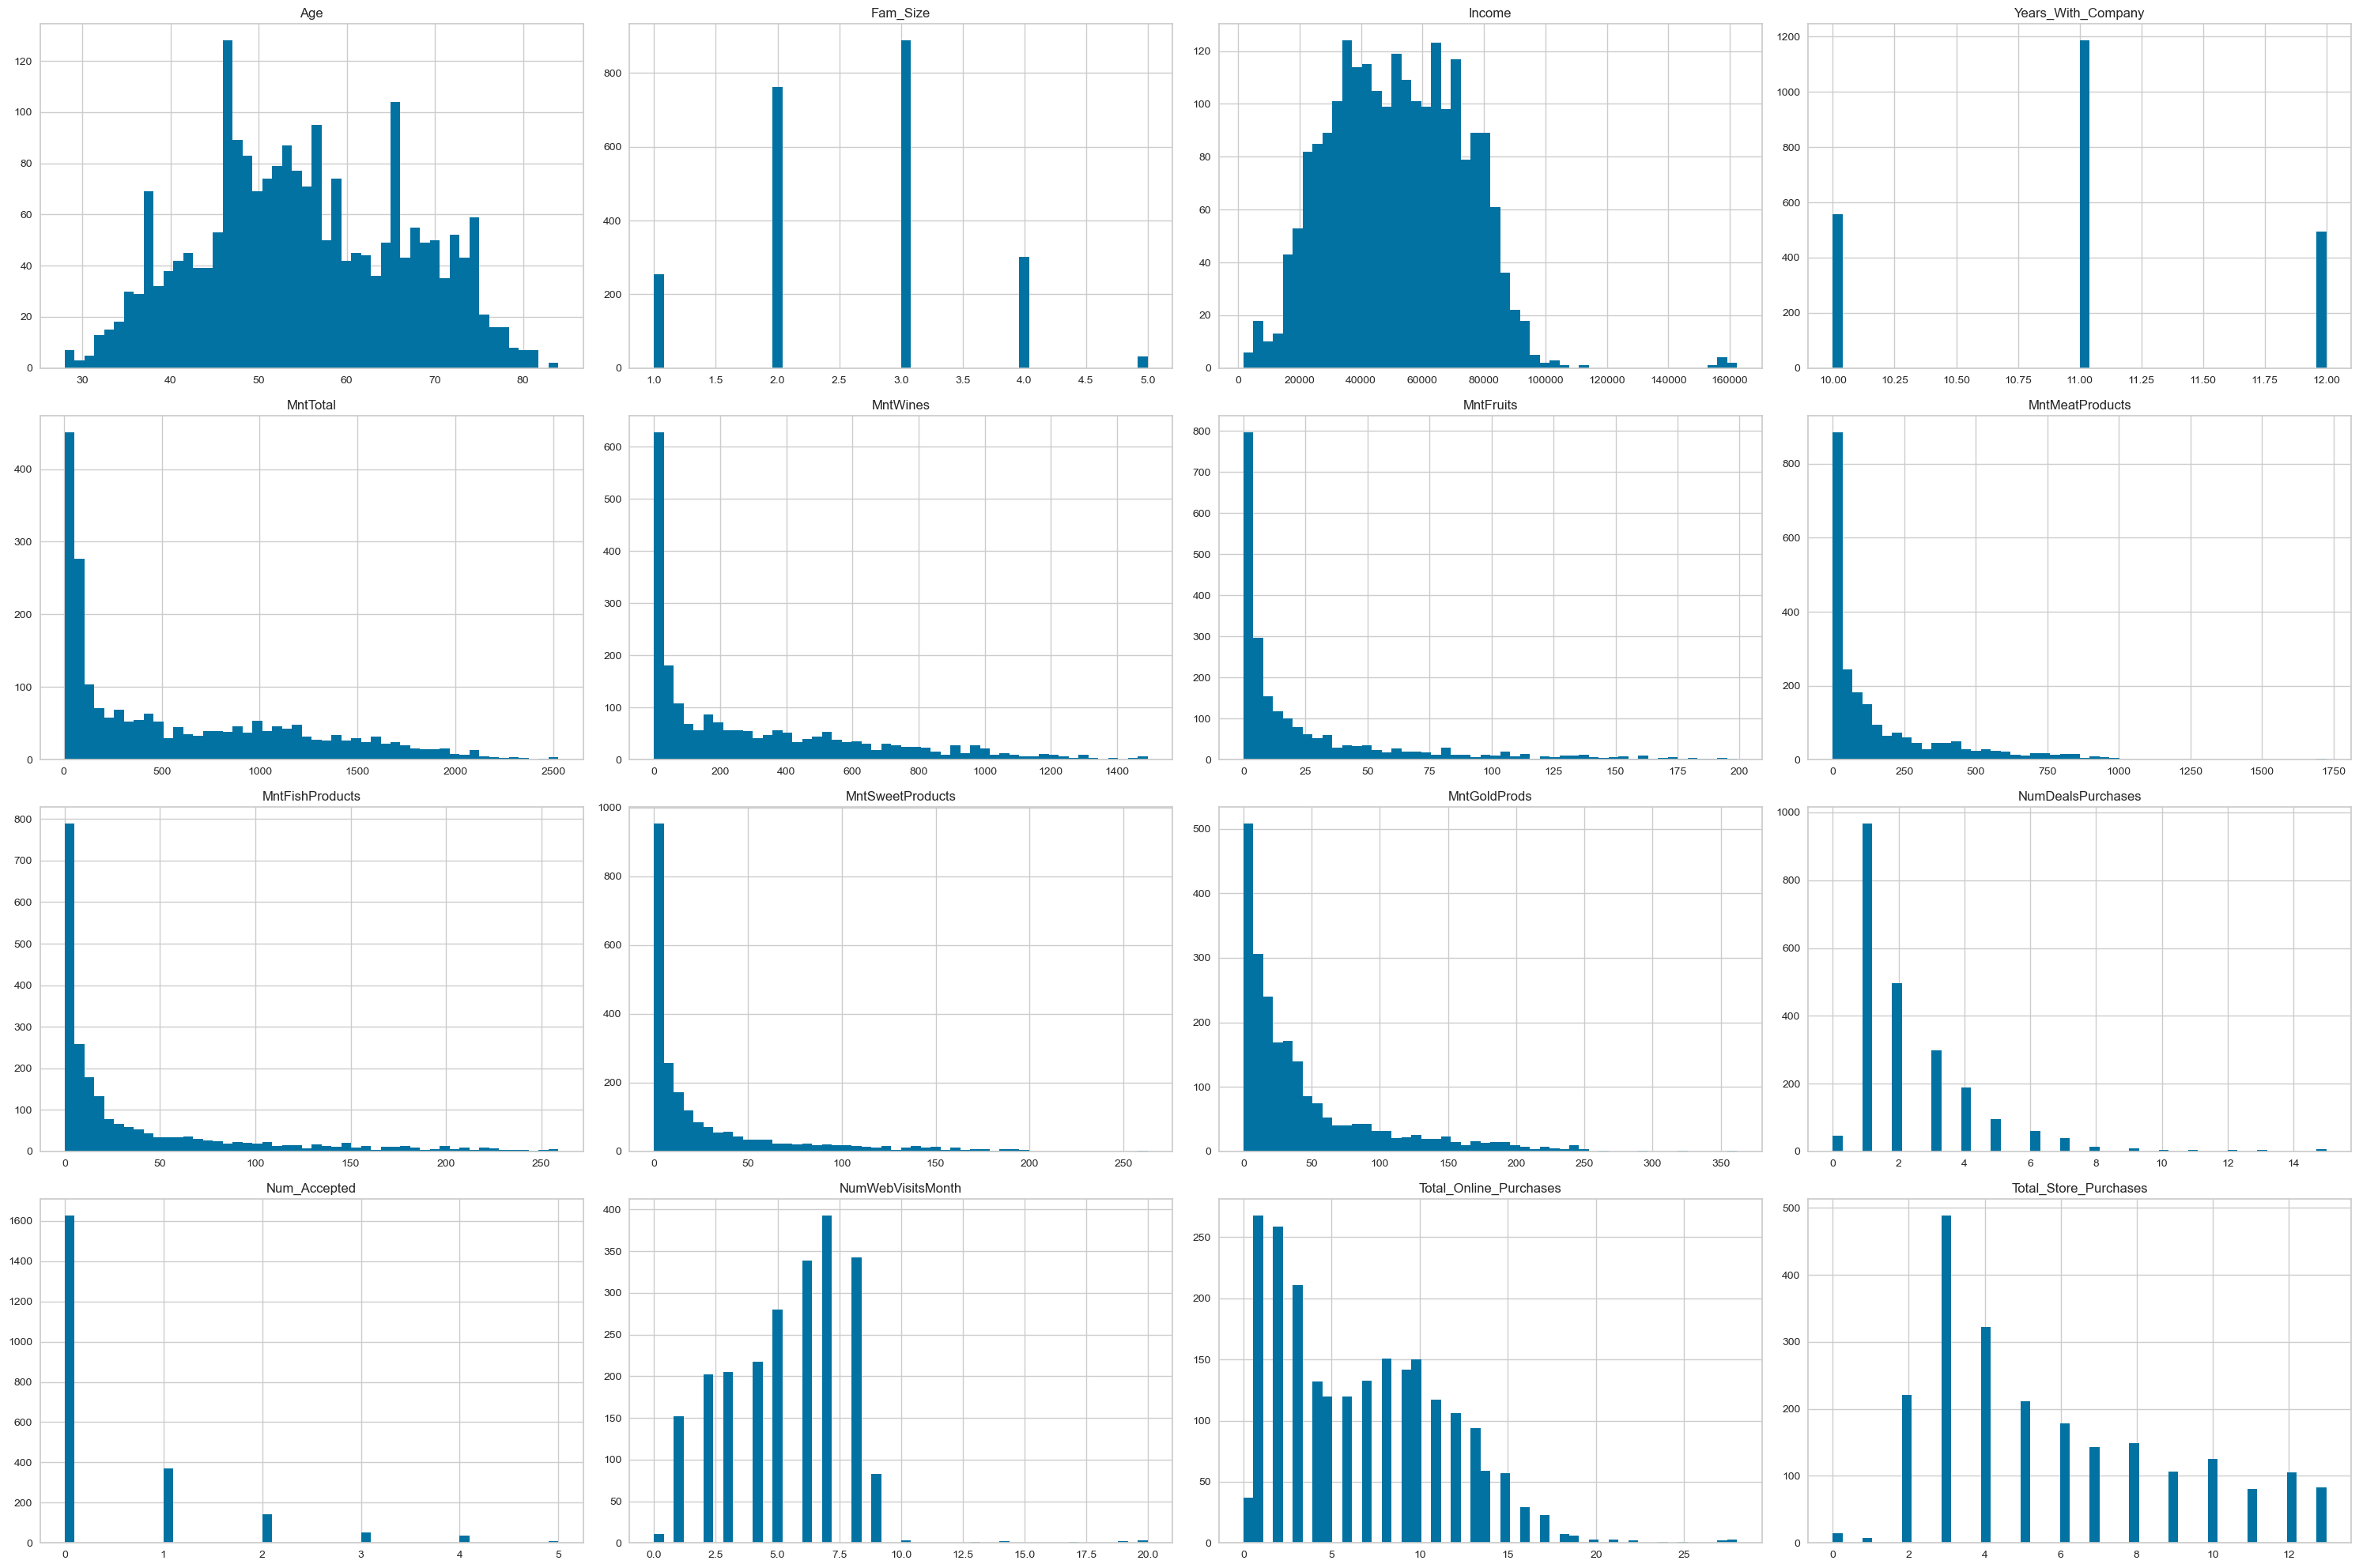

In [46]:
columns_to_plot = ['Age','Fam_Size','Income','Years_With_Company','MntTotal','MntWines','MntFruits','MntMeatProducts','MntFishProducts',
                   'MntSweetProducts','MntGoldProds','NumDealsPurchases','Num_Accepted','NumWebVisitsMonth',
                   'Total_Online_Purchases','Total_Store_Purchases']

# Setting up the figure with a grid layout
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(30, 20))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop over the columns and create a histogram for each
for i, col in enumerate(columns_to_plot):
    ds[col].hist(bins=50, ax=axes[i])
    axes[i].set_title(col)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

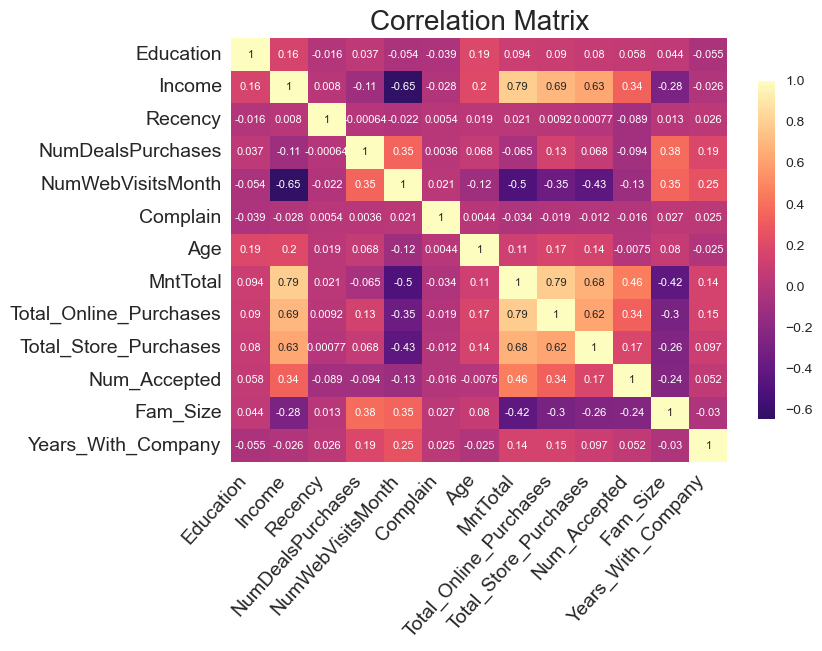

In [48]:
#plots the correlation matrix

columns_to_exclude = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts',
                   'MntSweetProducts','MntGoldProds',]
ds_modified = ds.drop(columns=columns_to_exclude)


# Create heatmap with larger labels
sns.heatmap(ds_modified.corr(), 
            annot=True, 
            cmap='magma', 
            center=0, 
            annot_kws={'size': 8},  # Set annotation font size
            xticklabels=ds_modified.corr().columns,  # Set x tick labels
            yticklabels=ds_modified.corr().columns,  # Set y tick labels
            cbar_kws={"shrink": .8})

# Increase the font size for x and y labels
plt.xticks(rotation=48, fontsize=14, ha='right')
plt.yticks(fontsize=14)

# Title with increased font size
plt.title('Correlation Matrix', fontsize=20)

plt.savefig('heatmap_less_columns.png')
plt.show()

## PCA 

In [62]:
sc= StandardScaler()
df= sc.fit_transform(ds)

In [63]:
df.shape

(2236, 19)

In [64]:
# Palette for DBSCAN and Kmeans Clusters

palette_dbscan = ['#808080',  # Grey for outliers
                  '#38B000',  # Green for cluster 1
                  '#168AAD',  # Blue for cluster 2 
                  '#D00000']  # Red for cluster 3


palette_kmeans = ['#38B000',  # Green for cluster 1
                  '#168AAD',  # Blue for cluster 2 
                  '#D00000']  # Red for cluster 3

### PCA dim = 3 

In [65]:
pca3 = PCA(n_components=3)
pca3.fit(df)
pca_fittata3 = pca3.transform(df)
print('Dimentionality Reduced Data:')
print(pca_fittata3[0])

Dimentionality Reduced Data:
[ 4.14845672  0.60334171 -1.92749152]


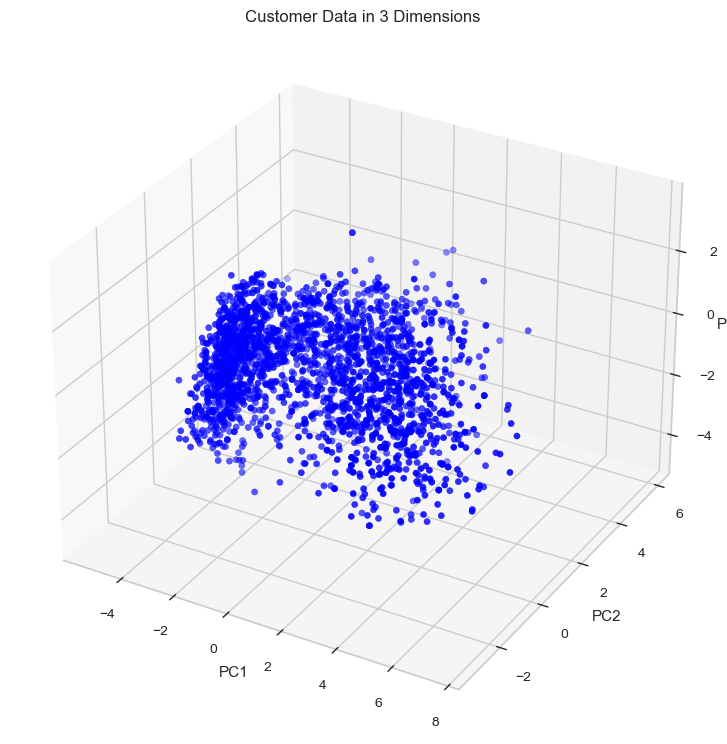

In [66]:
df_pca = pd.DataFrame(data=pca_fittata3, columns=['PC1', 'PC2', 'PC3'])
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(121, projection='3d')

# Scatter plot delle componenti principali
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c='blue', marker='o')

# Etichette degli assi
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Titolo del grafico
ax.set_title('Customer Data in 3 Dimensions')

plt.savefig("pca.png",format="png")
plt.show()

In [67]:
explained_variance = pca3.explained_variance_ratio_

# Display of the explained variance
print('Explained variance ratio for each principal component:')
for i, variance in enumerate(explained_variance):
    print(f'PC{i + 1}: {variance:.2f}')

total_variance_explained = sum(explained_variance)
print(f'Total variance explained by the first 3 PCs: {total_variance_explained:.2f}')


Explained variance ratio for each principal component:
PC1: 0.36
PC2: 0.09
PC3: 0.08
Total variance explained by the first 3 PCs: 0.53


## Kmeans

### K Estimation 

In [175]:
# Define number of clusters to try
k_values = range(2, 15)

# Silhouette Method
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(pca_fittata3)
    score = silhouette_score(pca_fittata3, kmeans.labels_)
    silhouette_scores.append(score)

# Elbow Method
inertia = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(pca_fittata3)
    inertia.append(kmeans.inertia_)

# Gap Statistic Method
def compute_gap_statistic(pca_fittata3, k_values, n_refs=10):
    gaps = np.zeros(len(k_values))
    for idx, k in enumerate(k_values):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(pca_fittata3)
        inertia_k = kmeans.inertia_

        random_inertia = np.zeros(n_refs)
        for i in range(n_refs):
            random_data = np.random.rand(*pca_fittata3.shape)
            kmeans.fit(random_data)
            random_inertia[i] = kmeans.inertia_

        gaps[idx] = np.log(np.mean(random_inertia)) - np.log(inertia_k)

    return gaps

gaps = compute_gap_statistic(pca_fittata3, k_values)



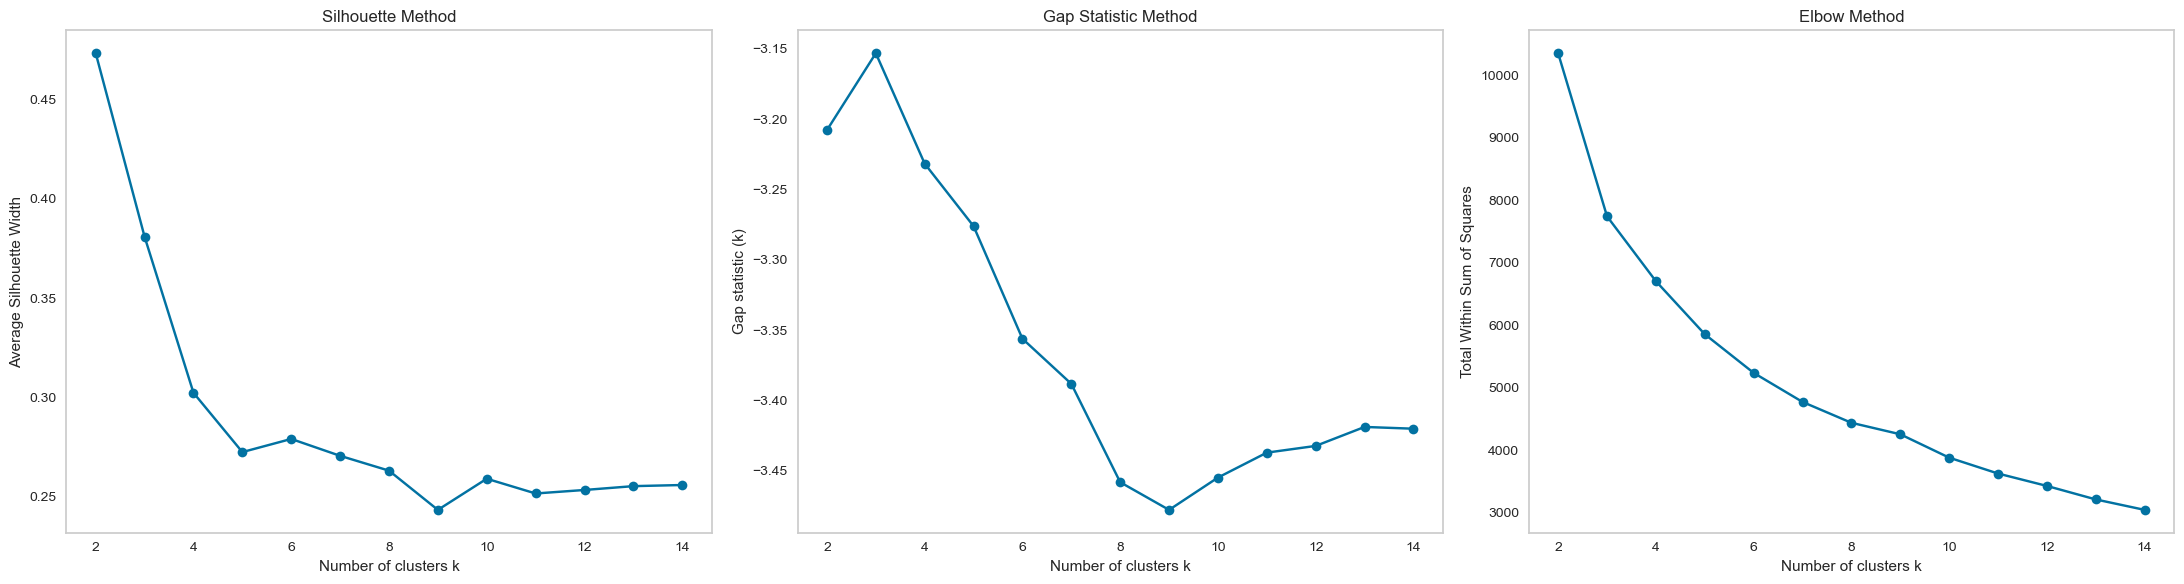

In [176]:

plt.figure(figsize=(22, 6))

# Silhouette Method
plt.subplot(1, 3, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of clusters k')
plt.ylabel('Average Silhouette Width')
plt.grid()

# Gap Statistic Method
plt.subplot(1, 3, 2)
plt.plot(k_values, gaps, marker='o')
plt.title('Gap Statistic Method')
plt.xlabel('Number of clusters k')
plt.ylabel('Gap statistic (k)')
plt.grid()

# Plot Elbow Method 
plt.subplot(1, 3, 3)
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters k')
plt.ylabel('Total Within Sum of Squares')
plt.grid()

plt.tight_layout()
plt.savefig("estim.png", format= "png")
plt.show()


### Kmeans 3D

In [177]:
kmeans = KMeans(3)
kmeans_labels = kmeans.fit_predict(df_pca)

df_pca["kmeans"] = kmeans_labels
df_pca['kmeans'] = pd.Categorical(df_pca['kmeans'])

### Plot of Clusters

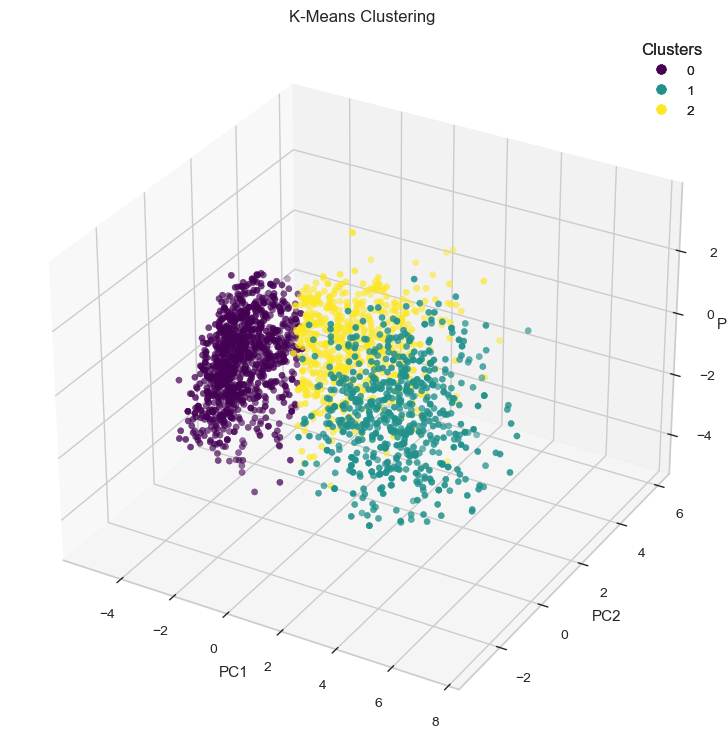

In [178]:
fig = plt.figure(figsize=(20, 20))

# Plot K-Means Clustering
ax1 = fig.add_subplot(121, projection='3d')
scatter_kmeans = ax1.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=df_pca['kmeans'], cmap='viridis', marker='o')
ax1.set_title('K-Means Clustering')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
legend1 = ax1.legend(*scatter_kmeans.legend_elements(), title="Clusters")
ax1.add_artist(legend1)

plt.show()


In [179]:
data_kmeans = ds.copy()

data_kmeans.loc[:,'Cluster'] = kmeans.labels_ + 1

In [180]:
data_kmeans.head()

Education   Income  Recency  MntWines  MntFruits  MntMeatProducts  \
0          1  58138.0       58       635         88              546   
1          1  46344.0       38        11          1                6   
2          1  71613.0       26       426         49              127   
3          1  26646.0       26        11          4               20   
4          2  58293.0       94       173         43              118   

   MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
0              172                88            88                  3   
1                2                 1             6                  2   
2              111                21            42                  1   
3               10                 3             5                  2   
4               46                27            15                  5   

   NumWebVisitsMonth  Complain  Age  MntTotal  Total_Online_Purchases  \
0                  7         0   67      1617                      18   
1                  5         0   70        27                       2   
2                  4         0   59       776                      10   
3                  6         0   40        53                       2   
4                  5         0   43       422                       8   

   Total_Store_Purchases  Num_Accepted  Fam_Size  Years_With_Company  Cluster  
0                      4             1         1                  12        2  
1                      2             0         3                  10        1  
2                     10             0         2                  11        2  
3                      4             0         3                  10        1  
4                      6             0         3                  10        3

In [193]:
numeric_df = data_kmeans.select_dtypes(include=['number'])

# Summarize of cluster characteristics by calculating the mean of numeric features for each cluster
cluster_summary_kmeans = numeric_df.groupby('Cluster').mean()

# Cluster summary in a table
print(tabulate(cluster_summary_kmeans, headers='keys', tablefmt='pretty'))

+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+----------------------+-------------------+--------------------+------------------------+-----------------------+---------------------+--------------------+--------------------+
| Cluster |     Education      |       Income       |      Recency       |      MntWines      |     MntFruits      |  MntMeatProducts   |  MntFishProducts  | MntSweetProducts  |    MntGoldProds    | NumDealsPurchases  | NumWebVisitsMonth  |       Complain       |        Age        |      MntTotal      | Total_Online_Purchases | Total_Store_Purchases |    Num_Accepted     |      Fam_Size      | Years_With_Company |
+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------

C:\Users\chiar\AppData\Local\Temp\ipykernel_13696\354560489.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




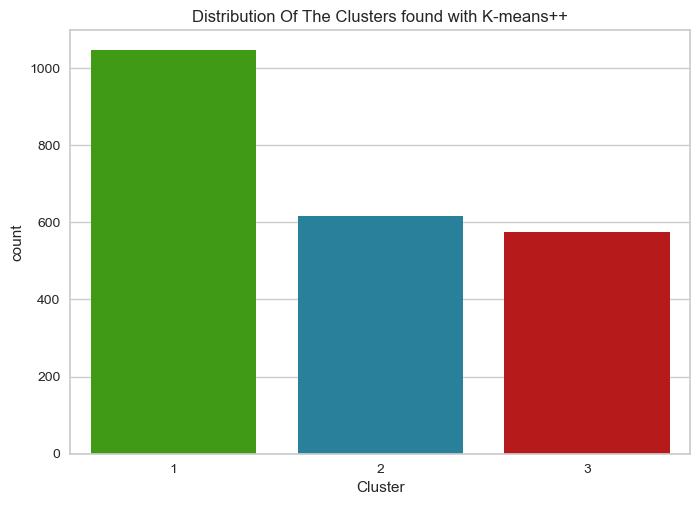

In [194]:
pl = sns.countplot(x=data_kmeans["Cluster"], palette=palette_kmeans)
pl.set_title("Distribution Of The Clusters found with K-means++")
plt.savefig("distr_kmeans.png",format="png")
plt.show()

In [195]:
clusters_kmean = np.array(kmeans_labels)

n_clusters_ = len(set(clusters_kmean)) 

print('Cluster Predictions')
print('-------------------------------')
print(f"Number of clusters: {n_clusters_}")
print('Number of points per cluster:')
for i in np.unique(clusters_kmean):            
    print(f'Cluster {i} : {np.sum(clusters_kmean == i)}')


Cluster Predictions
-------------------------------
Number of clusters: 3
Number of points per cluster:
Cluster 0 : 1046
Cluster 1 : 616
Cluster 2 : 574


### Density plots

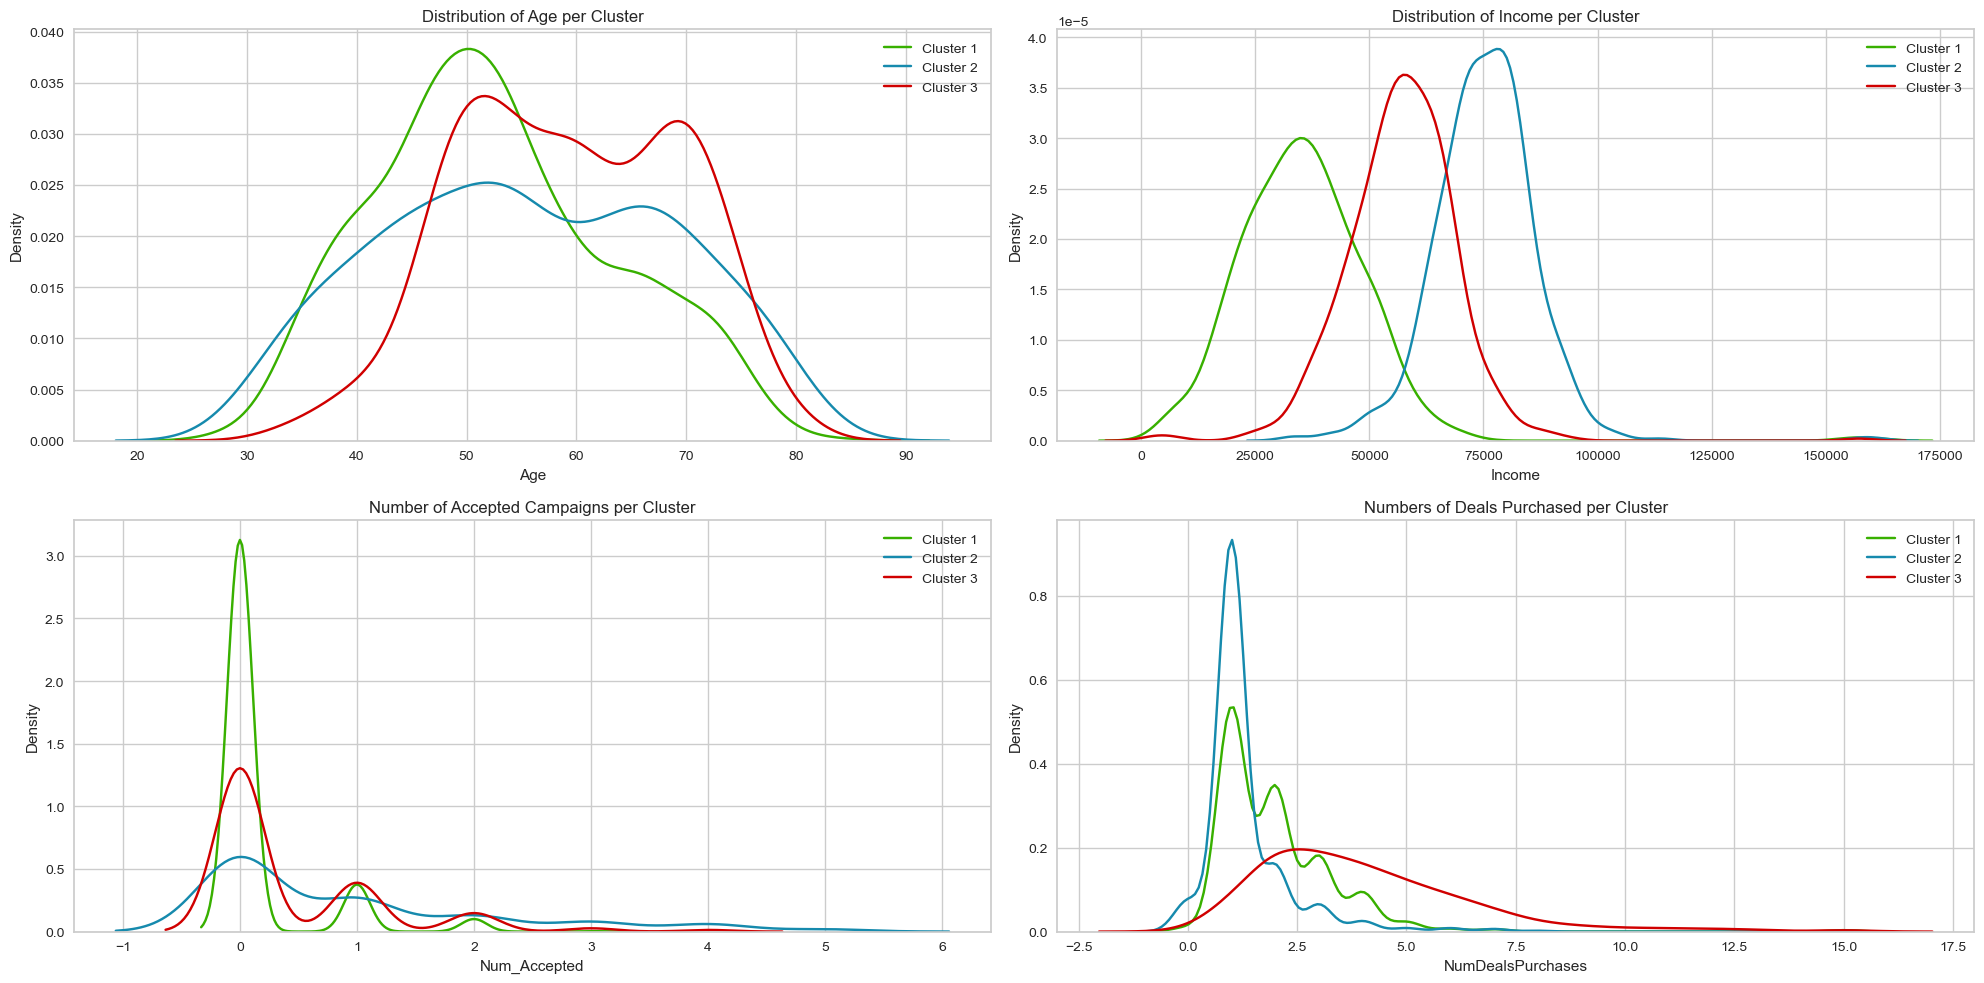

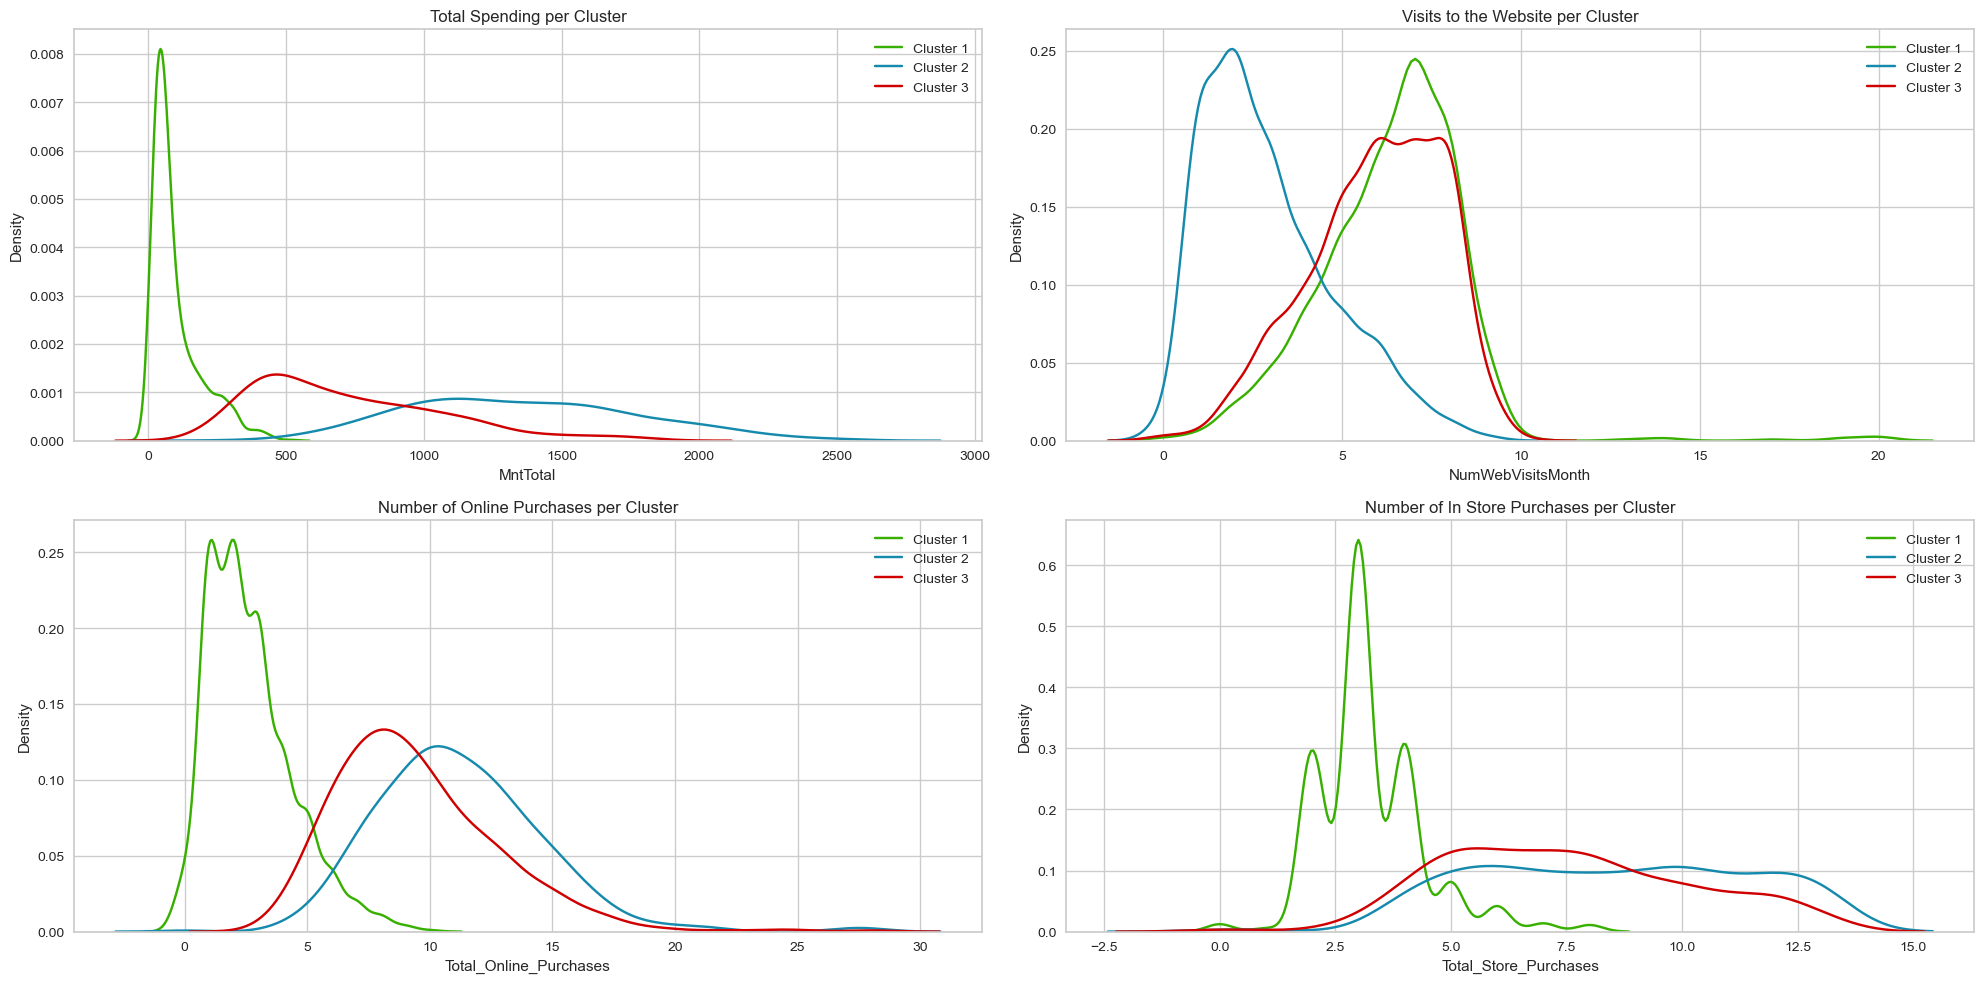

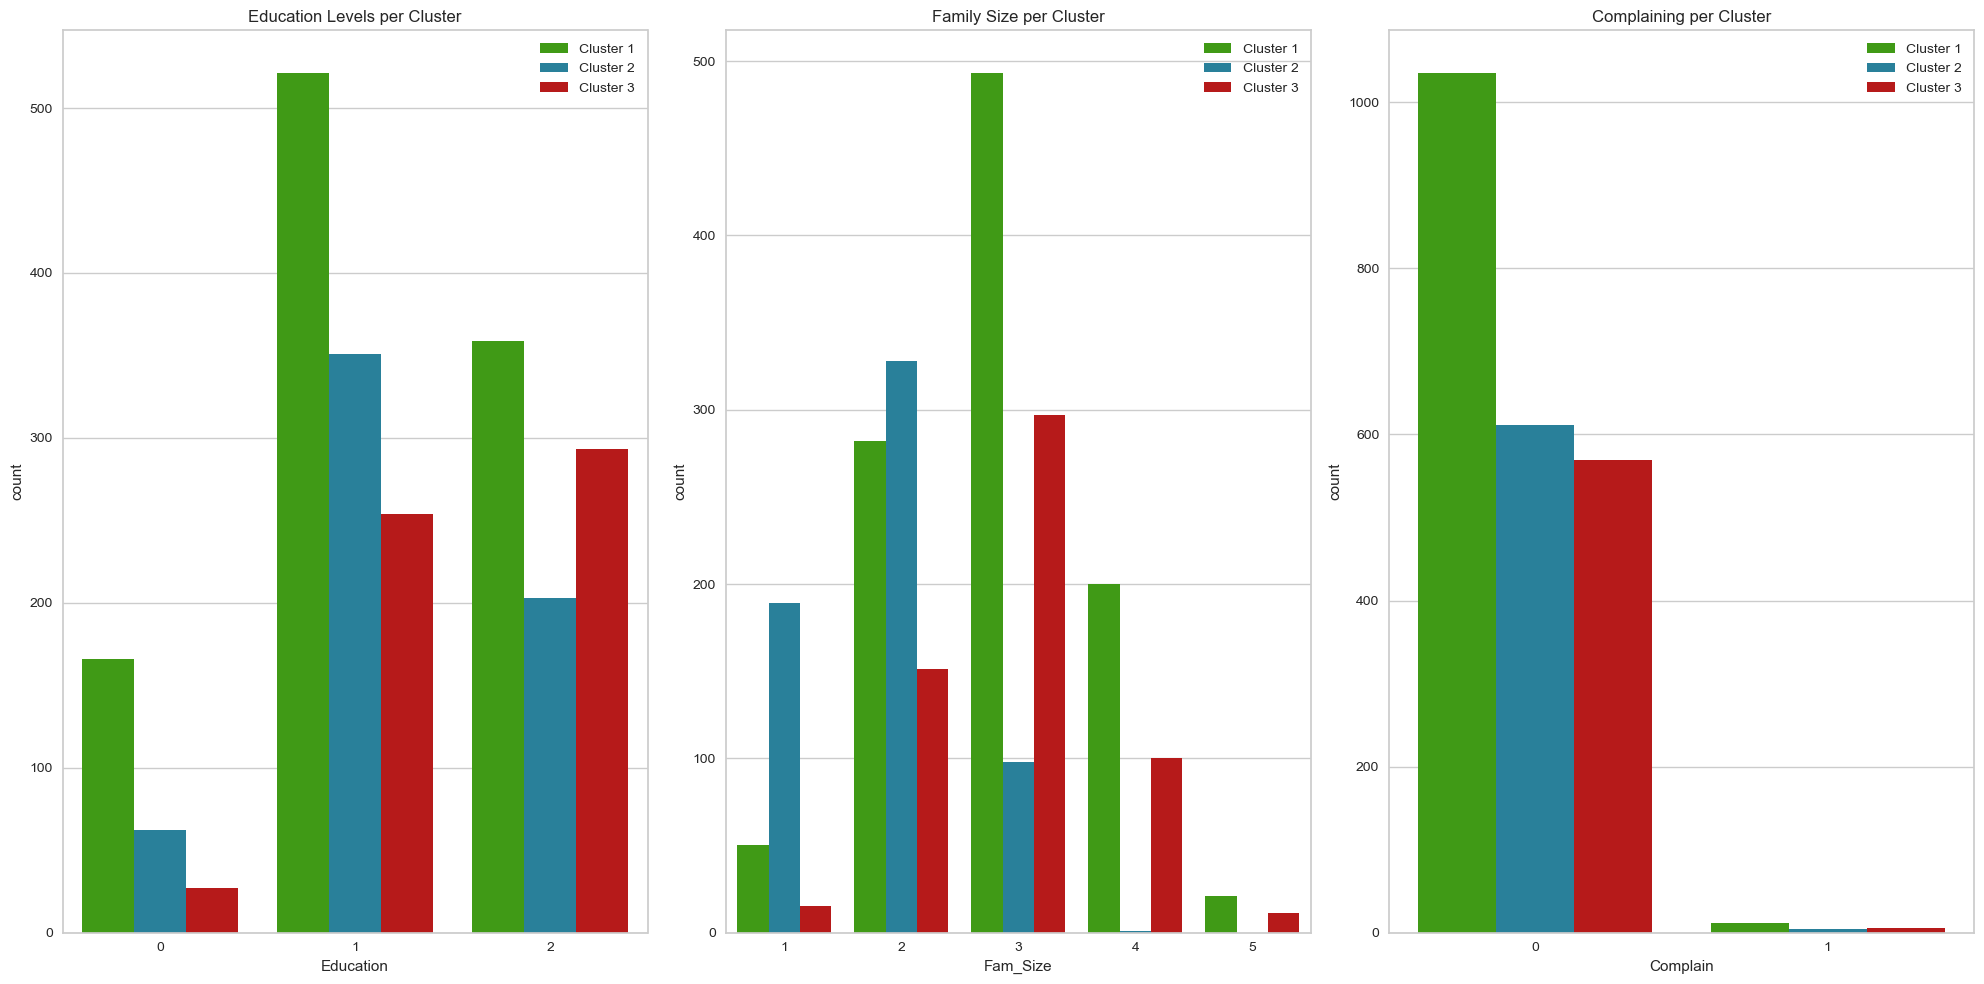

In [184]:
# Create new dataframes for each cluster
clus1_kmeans = data_kmeans[data_kmeans.Cluster == 1]
clus2_kmeans = data_kmeans[data_kmeans.Cluster == 2]
clus3_kmeans = data_kmeans[data_kmeans.Cluster == 3]

### Function to plot KDE (density) plots for KMeans clusters
def create_kdeplot_grid_kmeans(variables, nrows, ncols, figsize=(15, 10)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for ax, (col, title) in zip(axes.flatten(), variables):
        sns.kdeplot(data=clus1_kmeans, x=col, label='Cluster 1', color=palette_kmeans[0], ax=ax)
        sns.kdeplot(data=clus2_kmeans, x=col, label='Cluster 2', color=palette_kmeans[1], ax=ax)
        sns.kdeplot(data=clus3_kmeans, x=col, label='Cluster 3', color=palette_kmeans[2], ax=ax)
        ax.set_title(title)
        ax.legend()
    plt.tight_layout()
    plt.show()



# Create a function to plot bar plots in a grid
def create_barplot_grid_kmeans(variables, nrows, ncols, figsize=(15, 10)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for ax, (col, title) in zip(axes.flatten(), variables):
        sns.countplot(x=data_kmeans[col], hue=data_kmeans["Cluster"], palette=palette_kmeans, ax=ax)
        ax.set_title(title)
        ax.legend([ 'Cluster 1', 'Cluster 2', 'Cluster 3'])
    plt.tight_layout()
    plt.show()


# Variables for which to create the KDE plots
vars_to_kdeplot1_kmeans = [
    ('Age', 'Distribution of Age per Cluster'),
    ('Income', 'Distribution of Income per Cluster'),
    ('Num_Accepted', 'Number of Accepted Campaigns per Cluster'),
    ('NumDealsPurchases', 'Numbers of Deals Purchased per Cluster')
]

vars_to_kdeplot2_kmeans = [
    ('MntTotal', 'Total Spending per Cluster'),
    ('NumWebVisitsMonth', 'Visits to the Website per Cluster'),
    ('Total_Online_Purchases', 'Number of Online Purchases per Cluster'),
    ('Total_Store_Purchases', 'Number of In Store Purchases per Cluster')
]

# Create KDE plots for the first set of variables (2x2 grid)
create_kdeplot_grid_kmeans(vars_to_kdeplot1_kmeans, nrows=2, ncols=2, figsize=(20, 10))

# Create KDE plots for the second set of variables (2x2 grid)
create_kdeplot_grid_kmeans(vars_to_kdeplot2_kmeans, nrows=2, ncols=2, figsize=(20, 10))


# List of variables for bar plots
vars_to_barplot = [
    ('Education', 'Education Levels per Cluster'),
    ('Fam_Size', 'Family Size per Cluster'),
    ('Complain', 'Complaining per Cluster')
]

# Plot bar plots in a grid with the same figure size
create_barplot_grid_kmeans(vars_to_barplot, nrows=1, ncols=3, figsize=(20, 10))


## DBSCAN


In [68]:
clusters = dbscan(pca_fittata3,eps=0.725, minpts=25)    

In [69]:
df_pca['dbscan'] = clusters
df_pca['dbscan'] = pd.Categorical(df_pca['dbscan'])

In [70]:
clusters = np.array(clusters)

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Cluster Predictions')
print('-------------------------------')
print(f"Number of clusters: {n_clusters_}")
print(f"Number of noise points: {n_noise_}")
print('Number of points per cluster:')
for i in np.unique(clusters):            
    print(f'Cluster {i} : {np.sum(clusters == i)}')

Cluster Predictions
-------------------------------
Number of clusters: 3
Number of noise points: 713
Number of points per cluster:
Cluster -1 : 713
Cluster 1 : 1174
Cluster 2 : 271
Cluster 3 : 78


In [71]:
#append the clusters to the original dataset
data_dbscan = ds.copy() 
data_dbscan.loc[:,'Cluster'] = clusters

#creation of new dataframes for each cluster
outlier = data_dbscan[data_dbscan.Cluster == -1]
clus1 = data_dbscan[data_dbscan.Cluster == 1]
clus2 = data_dbscan[data_dbscan.Cluster == 2]
clus3 = data_dbscan[data_dbscan.Cluster == 3]

In [72]:
data_dbscan.head()

Education   Income  Recency  MntWines  MntFruits  MntMeatProducts  \
0          1  58138.0       58       635         88              546   
1          1  46344.0       38        11          1                6   
2          1  71613.0       26       426         49              127   
3          1  26646.0       26        11          4               20   
4          2  58293.0       94       173         43              118   

   MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
0              172                88            88                  3   
1                2                 1             6                  2   
2              111                21            42                  1   
3               10                 3             5                  2   
4               46                27            15                  5   

   NumWebVisitsMonth  Complain  Age  MntTotal  Total_Online_Purchases  \
0                  7         0   67      1617                      18   
1                  5         0   70        27                       2   
2                  4         0   59       776                      10   
3                  6         0   40        53                       2   
4                  5         0   43       422                       8   

   Total_Store_Purchases  Num_Accepted  Fam_Size  Years_With_Company  Cluster  
0                      4             1         1                  12       -1  
1                      2             0         3                  10        1  
2                     10             0         2                  11        2  
3                      4             0         3                  10        1  
4                      6             0         3                  10        1

In [73]:

numeric_df_dbscan = data_dbscan.select_dtypes(include=['number'])

# Summarize of the cluster characteristics by calculating the mean of numeric features for each cluster
cluster_summary_dbscan = numeric_df_dbscan.groupby(data_dbscan['Cluster']).mean()

# Cluster summary 
from tabulate import tabulate
print(tabulate(cluster_summary_dbscan, headers='keys', tablefmt='pretty'))

+---------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+----------------------+--------------------+--------------------+------------------------+-----------------------+---------------------+--------------------+--------------------+---------+
| Cluster |     Education      |       Income       |      Recency       |     MntWines      |     MntFruits      |  MntMeatProducts   |  MntFishProducts  | MntSweetProducts  |   MntGoldProds    | NumDealsPurchases  | NumWebVisitsMonth |       Complain       |        Age         |      MntTotal      | Total_Online_Purchases | Total_Store_Purchases |    Num_Accepted     |      Fam_Size      | Years_With_Company | Cluster |
+---------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+------------

### Plot of Clusters

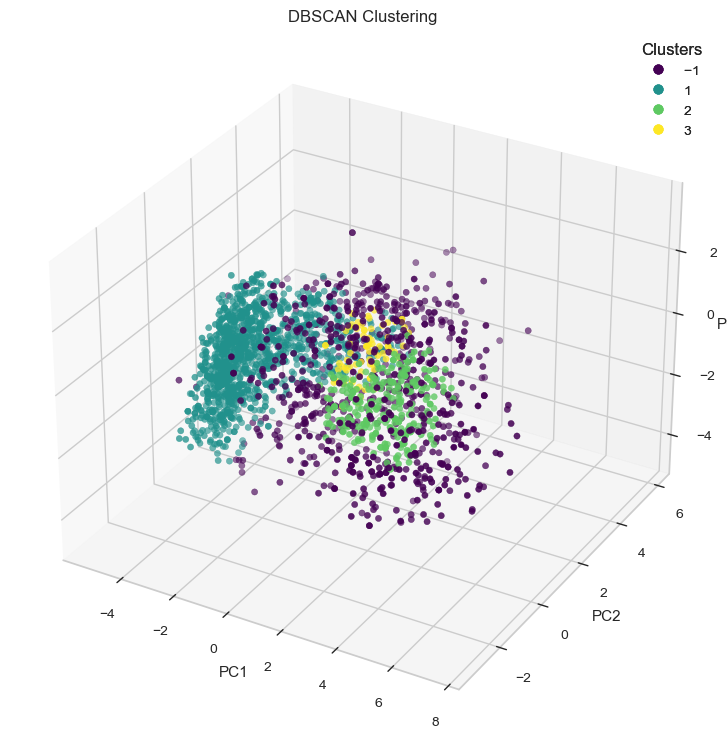

In [74]:
fig = plt.figure(figsize=(20, 20))


ax2 = fig.add_subplot(121, projection='3d')

scatter_dbscan = ax2.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=clusters, cmap='viridis', marker='o')
ax2.set_title('DBSCAN Clustering')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
legend2 = ax2.legend(*scatter_dbscan.legend_elements(), title="Clusters")
ax2.add_artist(legend2)
plt.show()


C:\Users\chiar\AppData\Local\Temp\ipykernel_8360\3260495801.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data_dbscan["Cluster"],palette=palette_dbscan)


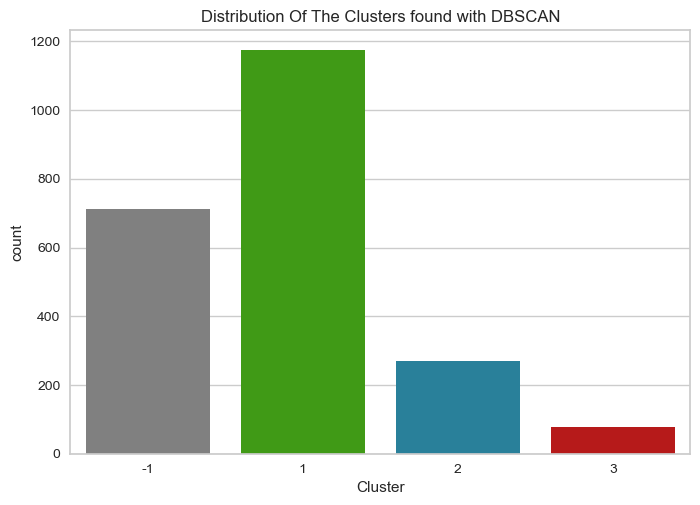

In [75]:
pl = sns.countplot(x=data_dbscan["Cluster"],palette=palette_dbscan)
pl.set_title("Distribution Of The Clusters found with DBSCAN")
plt.savefig("dbscan_count.png", format="png")
plt.show()

### Density Plots of Clusters

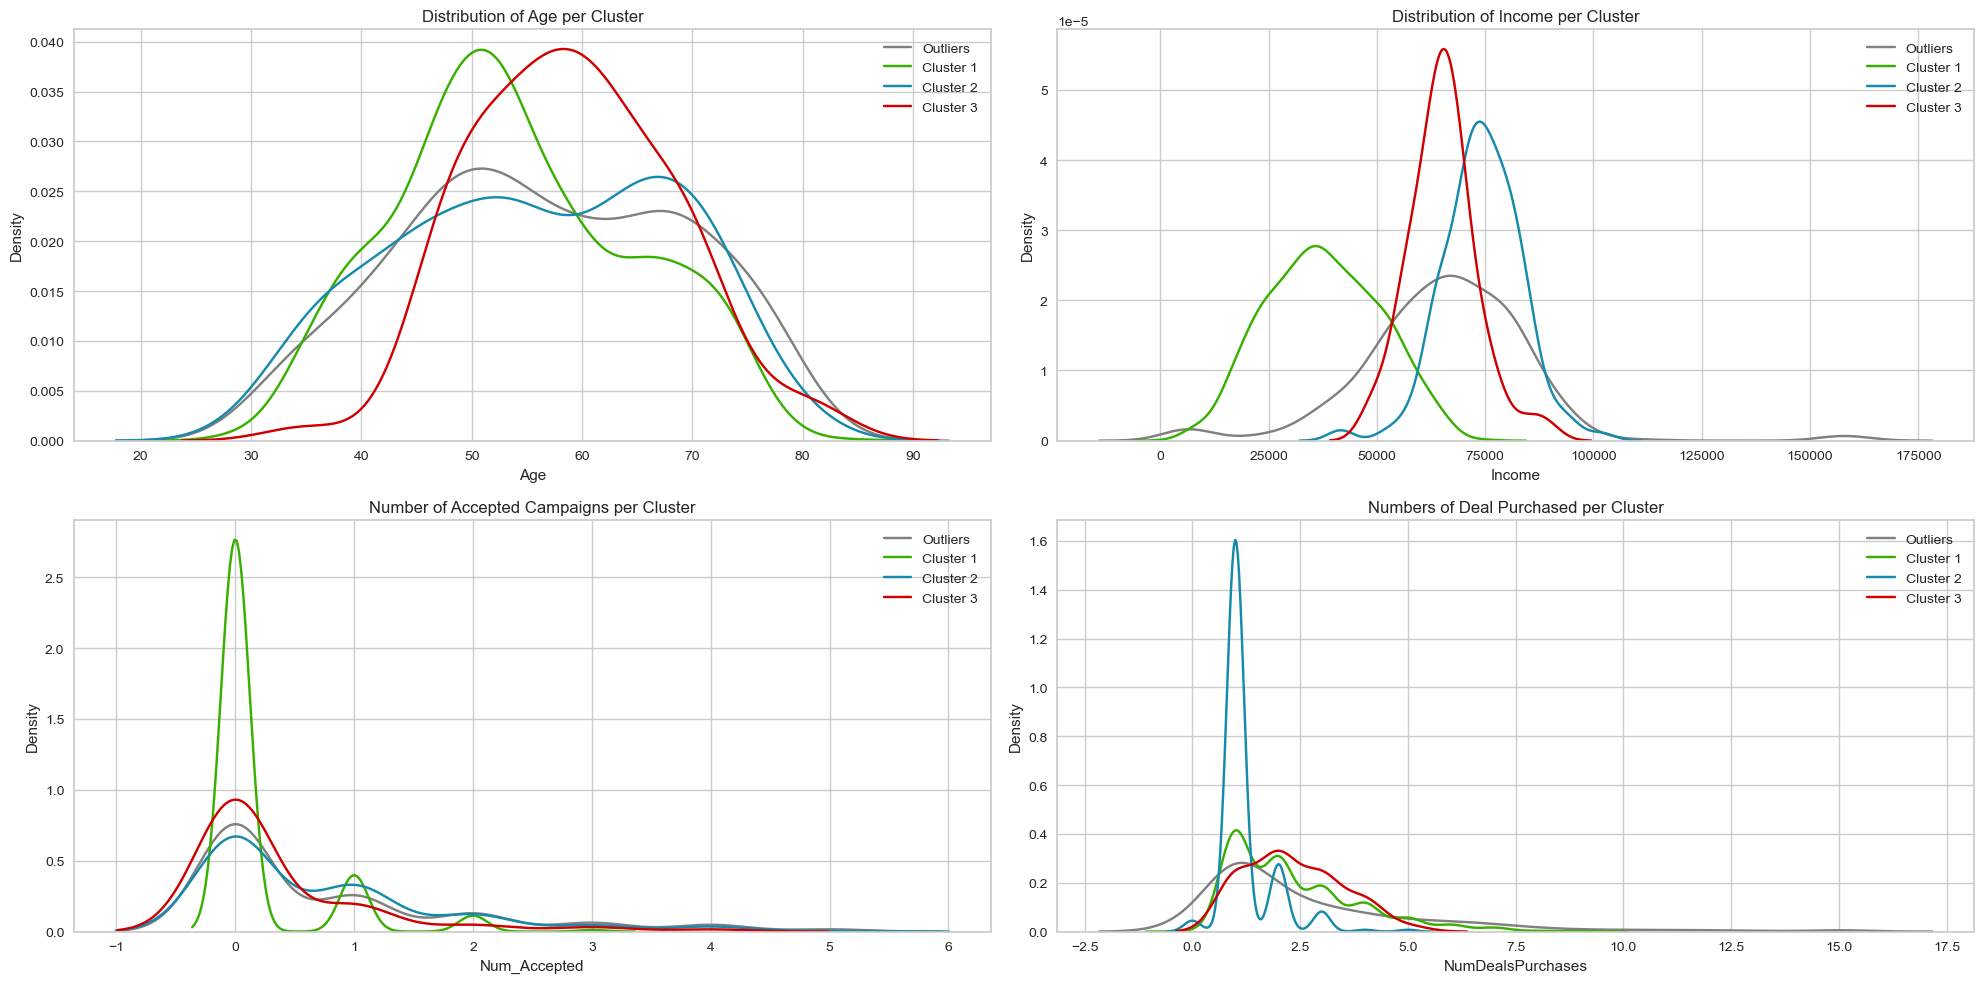

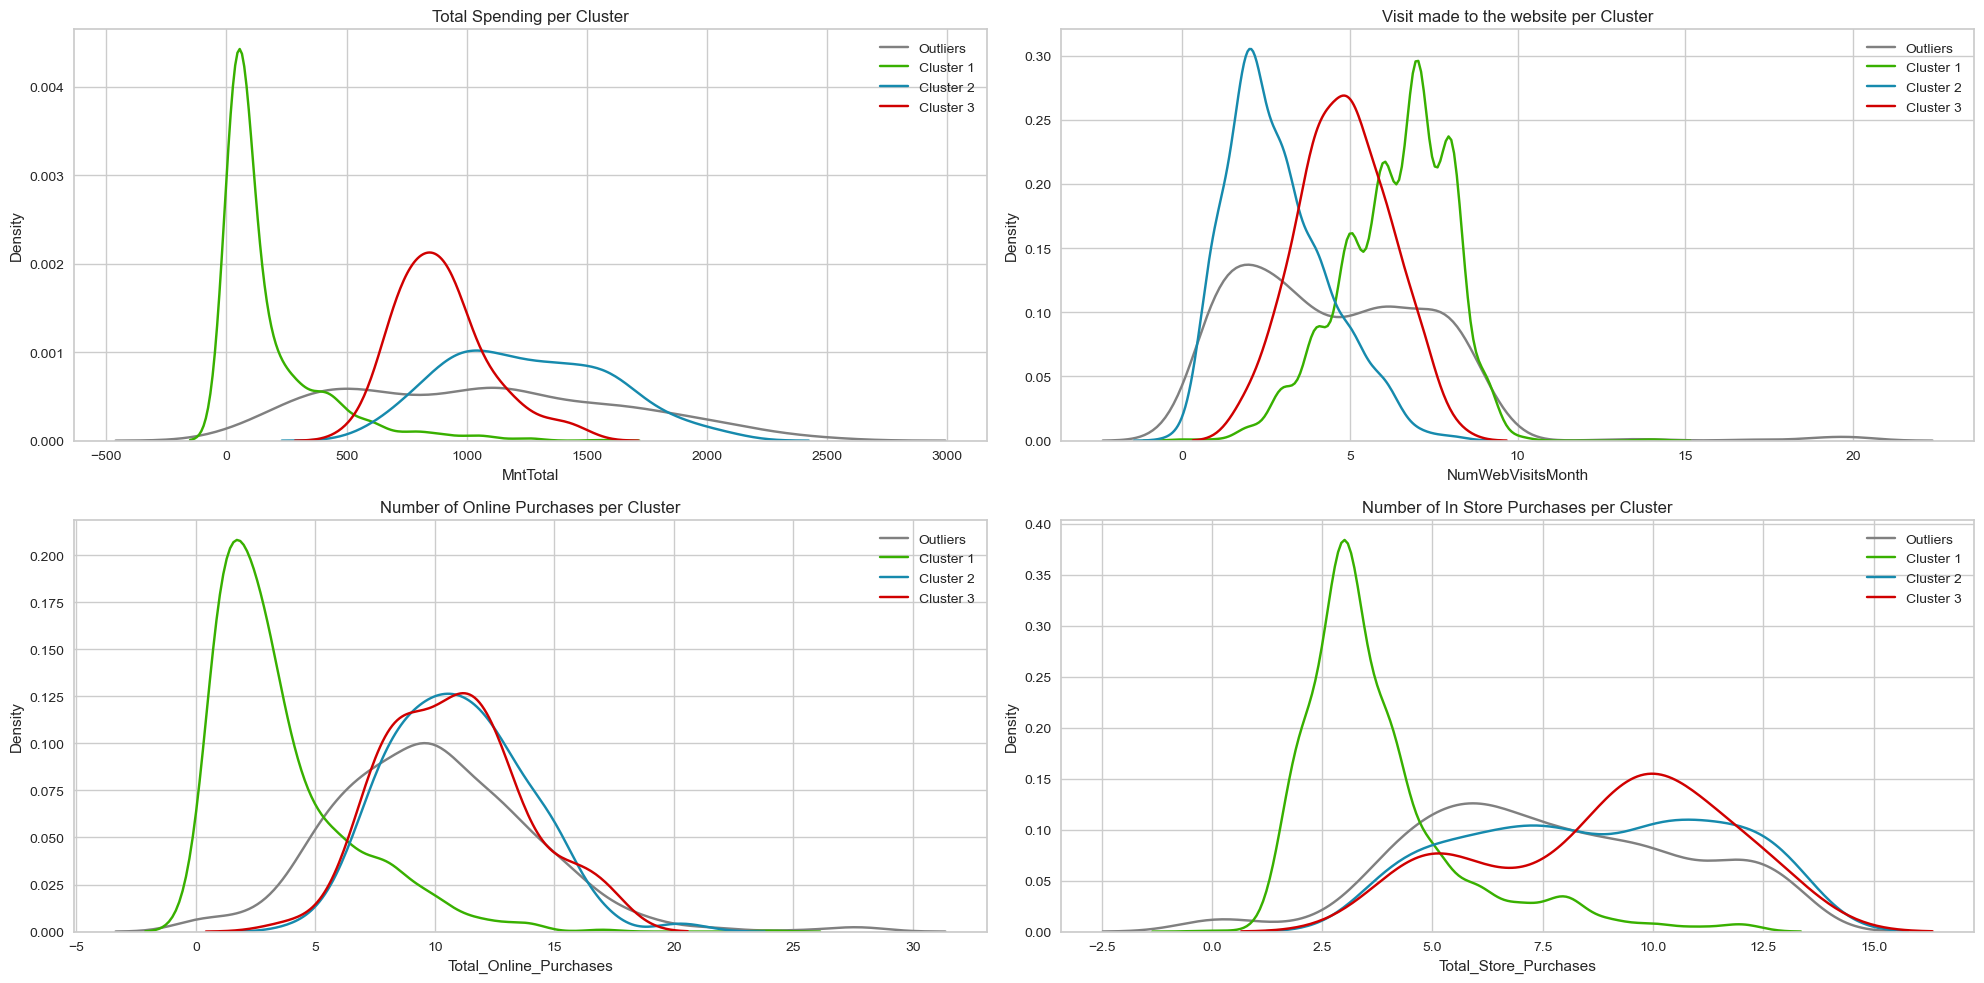

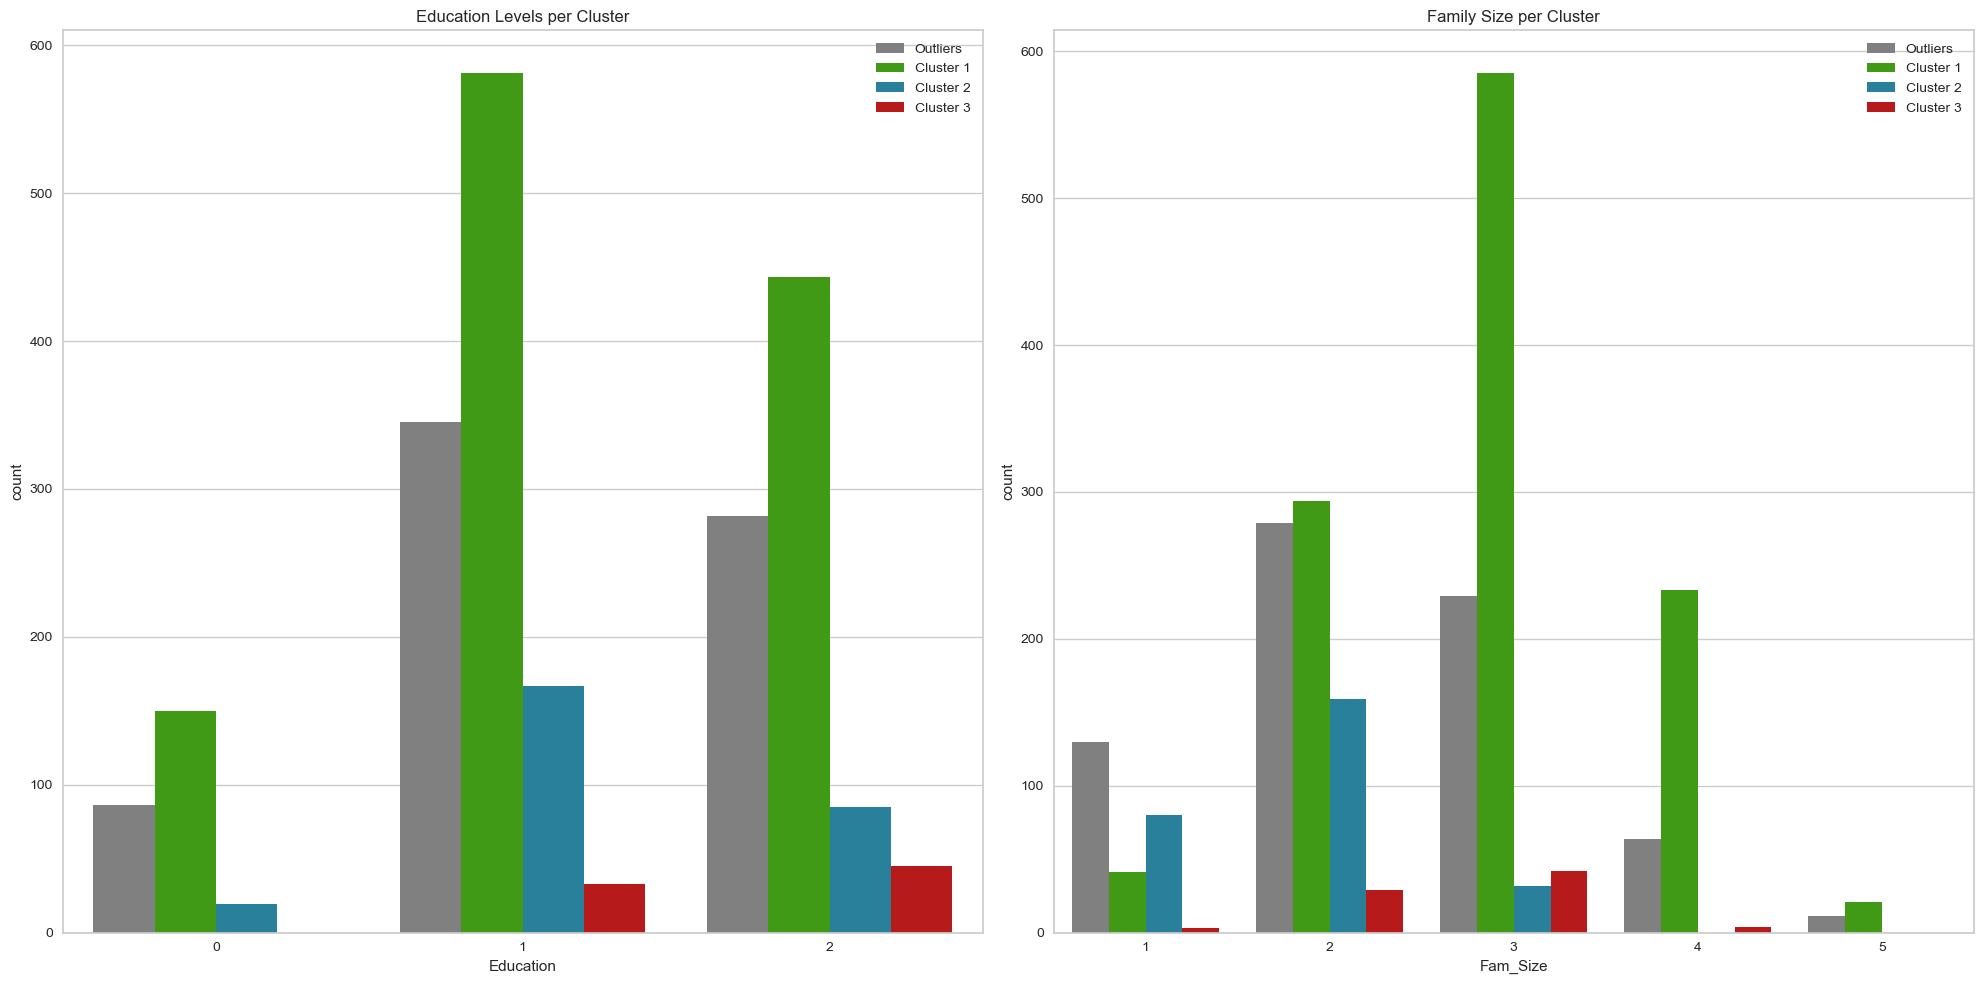

In [76]:

# Function to plot density plots in a grid (2x2)
def create_kdeplot_grid(variables, nrows, ncols,figsize=(15, 10)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for ax, (col, title) in zip(axes.flatten(), variables):
        sns.kdeplot(data=outlier, x=col, label='Outliers', color=palette_dbscan[0], ax=ax)
        sns.kdeplot(data=clus1, x=col, label='Cluster 1', color=palette_dbscan[1], ax=ax)
        sns.kdeplot(data=clus2, x=col, label='Cluster 2', color=palette_dbscan[2], ax=ax)
        sns.kdeplot(data=clus3, x=col, label='Cluster 3', color=palette_dbscan[3], ax=ax)
        ax.set_title(title)
        ax.legend()
    plt.tight_layout()
    plt.show()


def create_barplot_grid(variables, nrows, ncols, figsize=(15, 10)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for ax, (col, title) in zip(axes.flatten(), variables):
        sns.countplot(x=data_dbscan[col], hue=data_dbscan["Cluster"], palette=palette_dbscan, ax=ax)
        ax.set_title(title)
        ax.legend(['Outliers', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
    plt.tight_layout()
    plt.show()

# List of variables to plot distributions
vars_to_kdeplot1 = [
    ('Age', 'Distribution of Age per Cluster'),
    ('Income', 'Distribution of Income per Cluster'),
    ('Num_Accepted', 'Number of Accepted Campaigns per Cluster'),
    ('NumDealsPurchases', 'Numbers of Deal Purchased per Cluster')
]

vars_to_kdeplot2 = [
    ('MntTotal', 'Total Spending per Cluster'),
    ('NumWebVisitsMonth', 'Visit made to the website per Cluster'),
    ('Total_Online_Purchases', 'Number of Online Purchases per Cluster'),
    ('Total_Store_Purchases', 'Number of In Store Purchases per Cluster')
]

# List of variables to plot in bar graph 
vars_to_barplot = [
    ('Education', 'Education Levels per Cluster'),
    ('Fam_Size', 'Family Size per Cluster')
]


create_kdeplot_grid(vars_to_kdeplot1, nrows=2, ncols=2, figsize=(20, 10))


create_kdeplot_grid(vars_to_kdeplot2, nrows=2, ncols=2,figsize=(20, 10) )


create_barplot_grid(vars_to_barplot, nrows=1, ncols=2, figsize=(20, 10) ) 


### Scatterplots of Clusters

In [77]:
dataframe = pd.DataFrame(data_dbscan)
dataframe.head()

Education   Income  Recency  MntWines  MntFruits  MntMeatProducts  \
0          1  58138.0       58       635         88              546   
1          1  46344.0       38        11          1                6   
2          1  71613.0       26       426         49              127   
3          1  26646.0       26        11          4               20   
4          2  58293.0       94       173         43              118   

   MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
0              172                88            88                  3   
1                2                 1             6                  2   
2              111                21            42                  1   
3               10                 3             5                  2   
4               46                27            15                  5   

   NumWebVisitsMonth  Complain  Age  MntTotal  Total_Online_Purchases  \
0                  7         0   67      1617                      18   
1                  5         0   70        27                       2   
2                  4         0   59       776                      10   
3                  6         0   40        53                       2   
4                  5         0   43       422                       8   

   Total_Store_Purchases  Num_Accepted  Fam_Size  Years_With_Company  Cluster  
0                      4             1         1                  12       -1  
1                      2             0         3                  10        1  
2                     10             0         2                  11        2  
3                      4             0         3                  10        1  
4                      6             0         3                  10        1

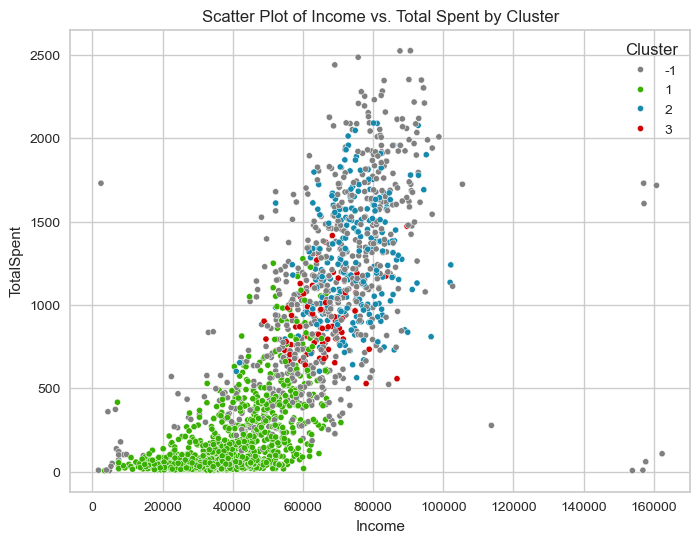

In [78]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Income', y='MntTotal', hue='Cluster', data=data_dbscan, palette = palette_dbscan, s=20)

plt.title('Scatter Plot of Income vs. Total Spent by Cluster')
plt.xlabel('Income')
plt.ylabel('TotalSpent')
plt.legend(title='Cluster')
plt.show()

# Clustering Evaluation Metrics


In [205]:
# Display Metrics
n_clusters_kmeans = len(set(kmeans_labels))  # Number of clusters
print('KMeans Metrics:')

# Silhouette Coefficient
silhouette_coeff1 = silhouette_score(pca_fittata3, kmeans_labels)
print(f'Silhouette Coefficient: {silhouette_coeff1}')

# Davies-Bouldin Index
db_index1 = davies_bouldin_score(pca_fittata3, kmeans_labels)
print(f'Davies-Bouldin Index: {db_index1}')

# Calinski-Harabasz Index
ch_index1 = calinski_harabasz_score(pca_fittata3, kmeans_labels)
print(f'Calinski-Harabasz Index: {ch_index1}')


KMeans Metrics:
Silhouette Coefficient: 0.38189268718361097
Davies-Bouldin Index: 1.0297062404339685
Calinski-Harabasz Index: 2111.754207036011


In [87]:
# DBSCAN Evaluation
dbscan_labels = clusters  

# Create a mask to filter out noise points
mask = dbscan_labels != -1

# Filter data and labels
filtered_data = pca_fittata3[mask]
filtered_labels = dbscan_labels[mask]

# Display Metrics
n_clusters_dbscan = len(set(filtered_labels))  # Number of clusters (excluding noise)
print('DBSCAN Metrics:')

# Silhouette Coefficient
silhouette_coeff2 = silhouette_score(filtered_data, filtered_labels)
print(f'Silhouette Coefficient: {silhouette_coeff2}')

# Davies-Bouldin Index
db_index2 = davies_bouldin_score(filtered_data, filtered_labels)
print(f'Davies-Bouldin Index: {db_index2}')

# Calinski-Harabasz Index
ch_index2 = calinski_harabasz_score(filtered_data, filtered_labels)
print(f'Calinski-Harabasz Index: {ch_index2}')


DBSCAN Metrics:
Silhouette Coefficient: 0.3746256451452183
Davies-Bouldin Index: 0.8587824511576994
Calinski-Harabasz Index: 1169.6772669162215


In [79]:
# DBSCAN Evaluation
dbscan_labels = clusters  
# Display Metrics
n_clusters_dbscan = len(set(dbscan_labels))  # Number of clusters
print('DBSCAN Metrics:')

# Silhouette Coefficient
silhouette_coeff2 = silhouette_score(pca_fittata3, dbscan_labels)
print(f'Silhouette Coefficient: {silhouette_coeff2}')

# Davies-Bouldin Index
db_index2 = davies_bouldin_score(pca_fittata3, dbscan_labels)
print(f'Davies-Bouldin Index: {db_index2}')

# Calinski-Harabasz Index
ch_index2 = calinski_harabasz_score(pca_fittata3, dbscan_labels)
print(f'Calinski-Harabasz Index: {ch_index2}')

DBSCAN Metrics:
Silhouette Coefficient: 0.13447330006842032
Davies-Bouldin Index: 3.1149729640197363
Calinski-Harabasz Index: 655.3628277896337


# Visualization of the Clusters in 3D 

In [207]:
import plotly.express as px

# Prepare the DataFrame (df_pca contains the PCA values and kmeans cluster labels)
fig = px.scatter_3d(df_pca, 
                    x='PC1', 
                    y='PC2', 
                    z='PC3', 
                    color='kmeans', 
                    title='K-Means++ Clustering',
                    labels={'PC1': 'PC1', 'PC2': 'PC2', 'PC3': 'PC3'},
                    color_discrete_sequence=palette_kmeans)


fig.update_traces(marker=dict(size=2.3))  # Set a fixed size for all points


fig.show(renderer='browser')

fig.write_html('kmeans_3d_plot.html')


In [208]:
# Prepare the 3D scatter plot for DBSCAN
fig = px.scatter_3d(df_pca, 
                    x='PC1', 
                    y='PC2', 
                    z='PC3', 
                    color='dbscan', 
                    title='DBSCAN Clustering',
                    labels={'PC1': 'PC1', 'PC2': 'PC2', 'PC3': 'PC3'},
                    color_discrete_sequence=palette_dbscan)

fig.update_traces(marker=dict(size=2.5))  # Set a fixed size for all points

# Show the plot interactively in the browser
fig.show(renderer='browser')

fig.write_html('dbscan_3d_plot.html')
